# Set-up

## Globals

In [359]:
# --- Standard library ---
import sys
import os

# --- Scientific computing ---
import numpy as np
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# --- Network science ---
import networkx as nx

# --- Data handling and visualization ---
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# --- Project source code ---
sys.path.append("../../src/")

from classifiers.features import get_degrees, get_configuration_probabilities_feature
from classifiers.features import get_distances, get_configuration_distances_feature, get_distance_ratios_feature
# from classifiers.features import get_labels, format_feature_matrix
from classifiers.logreg import *
from data.observations import get_preprocessed_data

In [360]:
SYSTEM = "drosophila"
LAYERS = [1, 2]
REP = 1

THETAS = [0.05,0.07,0.10,0.12,0.15,0.17,0.20,0.22,0.25,0.27,0.30,0.32,0.35,0.37,0.40,0.42,0.45,0.47,0.50,0.53,0.55,0.57,0.60,0.62,0.65,0.68,0.70,0.72,0.75,0.78,0.80,0.82,0.85,0.88,0.90,0.92,0.95]
# THETA = 0.50  # before threshold
# THETA = 0.65  # approaching threshold from the left
THETA = 0.68  # approaching threshold from the right
# THETA = 0.85  # after threshold

## Loading cache and applying transformations

In [361]:
cache = get_preprocessed_data(SYSTEM, LAYERS, THETA, REP)
cache.embeddings = cache.renormalize()
cache.embeddings = cache.align_centers()

# Precomputing features

In [362]:
edges = cache.observed_edges.copy()
edges.update(cache.unobserved_edges)

In [363]:
distances_G, distances_H = get_distances(cache.embeddings, edges.keys())

In [364]:
feature_c = get_configuration_distances_feature(distances_G, distances_H, zde_penalty=0.1)
feature_r = get_distance_ratios_feature(distances_G, distances_H, zde_penalty=0.1)

In [365]:
df = pd.DataFrame({
    "edge": edges.keys(),
    "layer_actual": edges.values(),
    "distance_G": distances_G,
    "distance_H": distances_H,
    "feature_c": feature_c,
    "feature_r": feature_r
})

## Transformations, melts, and pivots

In [366]:
# Adding useful transformation for unbounded feature
df["log_ratio"] = df["feature_r"].transform(np.log10)

# Notating TTS
df["tts"] = [
    "Train" if row[1]["edge"] in cache.observed_edges else "Test"
    for row in df.iterrows()
]

In [367]:
# Melting main quantitative variables
df_melted = df.melt(
    id_vars=["edge", "layer_actual", "distance_G", "distance_H", "tts"],
    value_vars=["feature_c", "feature_r", "log_ratio"],
    var_name="feature_type", value_name="feature_value"
)
df_melted = df_melted.melt(
    id_vars=["edge", "layer_actual", "feature_type", "feature_value", "tts"],
    value_vars=["distance_G", "distance_H"],
    var_name="distance_layer", value_name="distance"
)

In [368]:
df_melted = df_melted.replace({
    "distance_G": "G",
    "distance_H": "H",
    "feature_c": "Configuration",
    "feature_r": "Ratio",
    "log_ratio": "LogRatio"
})

# Simulated feature estimates

In [369]:
def s(x): return 1 / x

def configuration(x, y): return 2*(s(x) / (s(x) + s(y)))-1
def ratio(x, y): return s(x) / s(y)

def z(f, X, Y): return np.array([f(x, y) for x in X for y in Y]).reshape(len(X), len(Y))

In [370]:
pts_normal_scale = np.logspace(-3, 3, 1000)
pts_small_scale = np.logspace(-15, -6, 1000)
RESOLUTION = 100

Text(0.5, 1.0, 'Configuration Feature\n Normal scale, small scale')

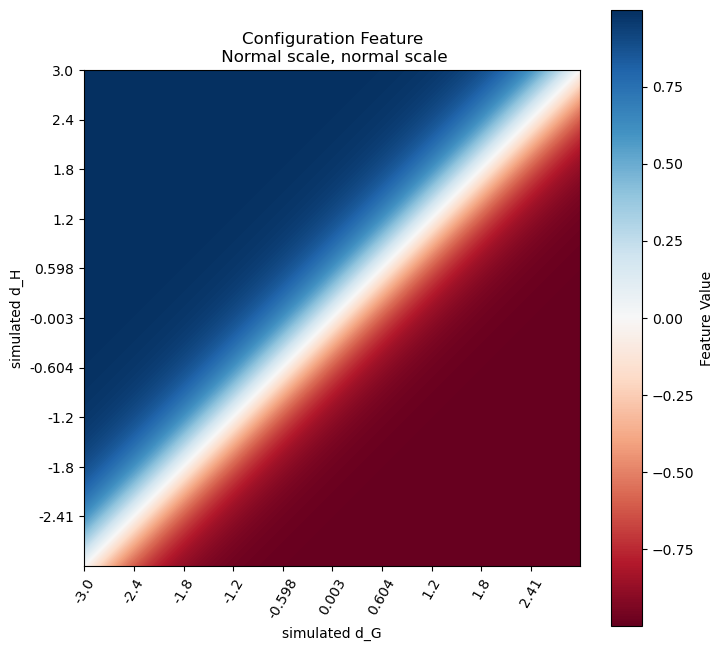

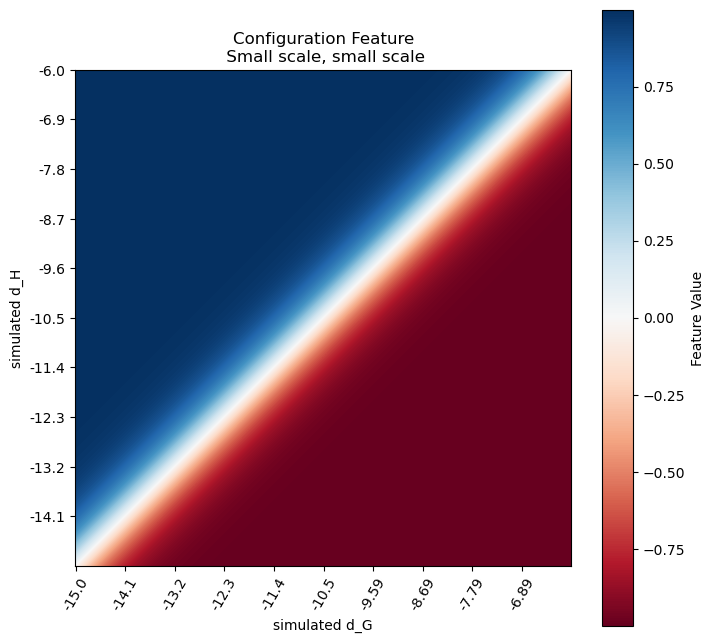

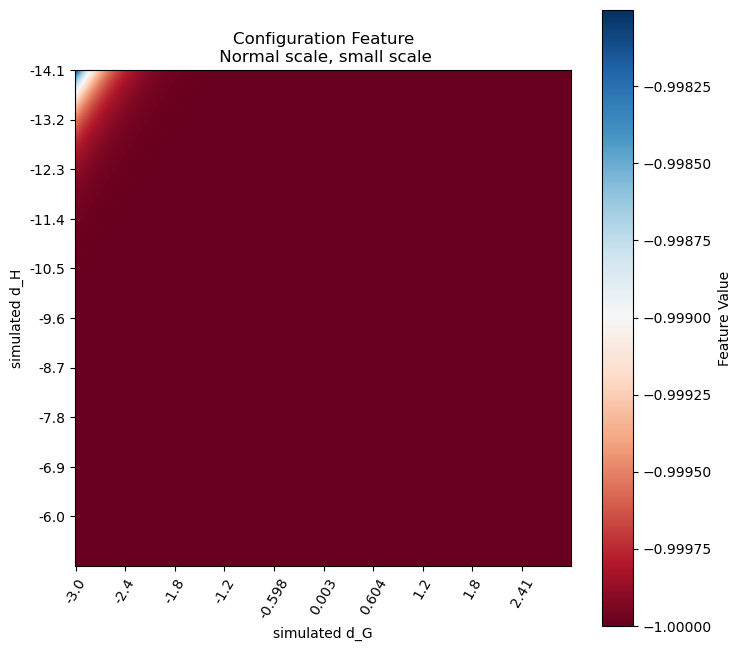

In [371]:
X = pts_normal_scale
Y = pts_normal_scale[::-1]
f = configuration

plt.figure(figsize=(8,8))
plt.imshow(z(f, X, Y), cmap="RdBu")

X_ = [
    float(np.format_float_scientific(x, 2))
    for x in np.log10(X[::RESOLUTION])
]
X__ = range(len(X))[::RESOLUTION]
Y_ = [
    float(np.format_float_scientific(y, 2))
    for y in np.log10(Y[::RESOLUTION])
]
Y__ = range(len(Y))[::RESOLUTION]
plt.xticks(X__, X_, rotation=60)
plt.yticks(Y__, Y_)

plt.xlabel("simulated d_G")
plt.ylabel("simulated d_H")

plt.colorbar(label="Feature Value")

plt.title("Configuration Feature\n Normal scale, normal scale")

# ================================================================
X = pts_small_scale
Y = pts_small_scale[::-1]

plt.figure(figsize=(8,8))
plt.imshow(z(f, X, Y), cmap="RdBu")

X_ = [
    float(np.format_float_scientific(x, 2))
    for x in np.log10(X[::RESOLUTION])
]
X__ = range(len(X))[::RESOLUTION]
Y_ = [
    float(np.format_float_scientific(y, 2))
    for y in np.log10(Y[::RESOLUTION])
]
Y__ = range(len(Y))[::RESOLUTION]
plt.xticks(X__, X_, rotation=60)
plt.yticks(Y__, Y_)

plt.xlabel("simulated d_G")
plt.ylabel("simulated d_H")

plt.colorbar(label="Feature Value")

plt.title("Configuration Feature\n Small scale, small scale")

# ================================================================
X = pts_normal_scale
Y = pts_small_scale[::-1]

plt.figure(figsize=(8,8))
plt.imshow(z(f, X, Y), cmap="RdBu")

X_ = [
    float(np.format_float_scientific(x, 2))
    for x in np.log10(X[::RESOLUTION])
]
X__ = range(len(X))[::RESOLUTION]
Y_ = [
    float(np.format_float_scientific(y, 2))
    for y in np.log10(Y[::RESOLUTION])
][::-1]
Y__ = range(len(Y))[::RESOLUTION]
plt.xticks(X__, X_, rotation=60)
plt.yticks(Y__, Y_)

plt.xlabel("simulated d_G")
plt.ylabel("simulated d_H")

plt.colorbar(label="Feature Value")

plt.title("Configuration Feature\n Normal scale, small scale")

Text(0.5, 1.0, 'Ratio Feature\n Normal scale, small scale')

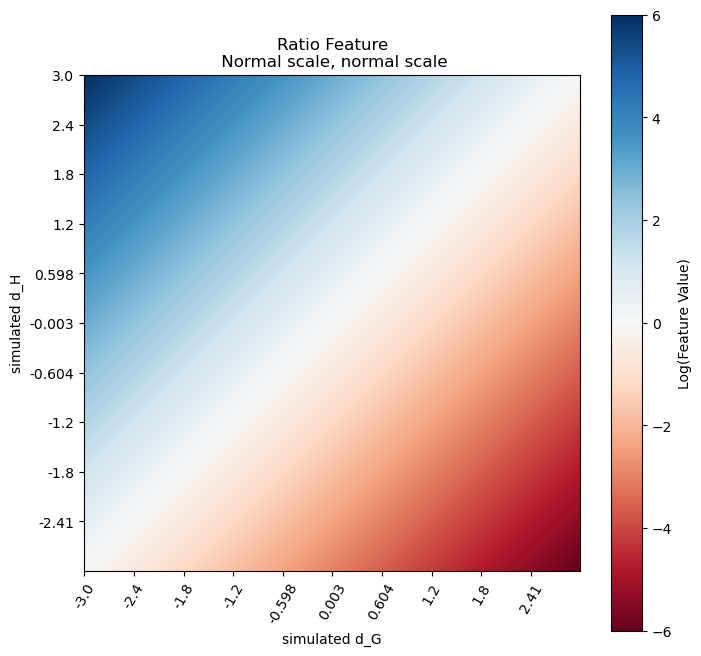

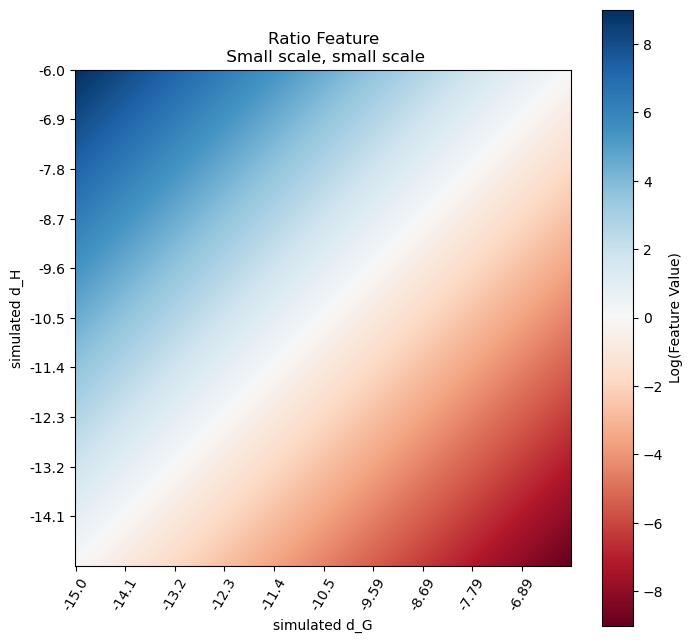

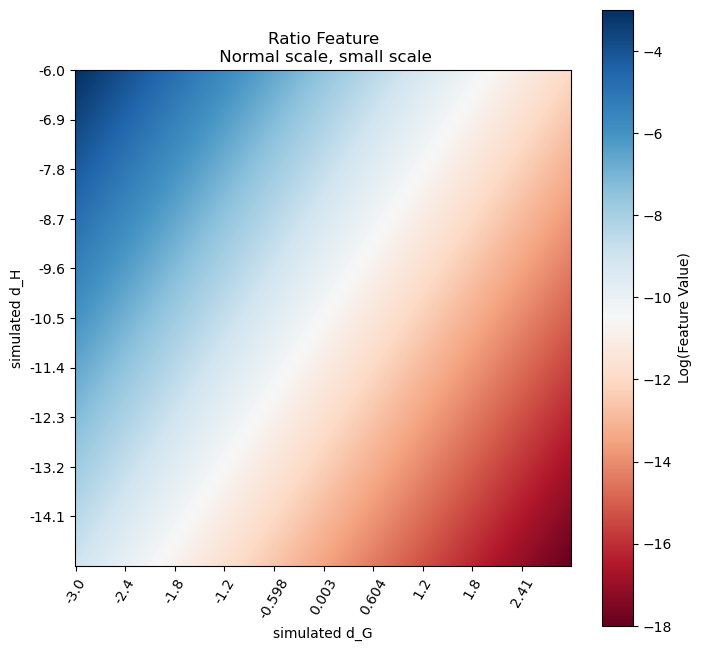

In [372]:
X = pts_normal_scale
Y = pts_normal_scale[::-1]
f = ratio

plt.figure(figsize=(8,8))
plt.imshow(np.log10(z(f, X, Y)), cmap="RdBu")

X_ = [
    float(np.format_float_scientific(x, 2))
    for x in np.log10(X[::RESOLUTION])
]
X__ = range(len(X))[::RESOLUTION]
Y_ = [
    float(np.format_float_scientific(y, 2))
    for y in np.log10(Y[::RESOLUTION])
]
Y__ = range(len(Y))[::RESOLUTION]
plt.xticks(X__, X_, rotation=60)
plt.yticks(Y__, Y_)

plt.xlabel("simulated d_G")
plt.ylabel("simulated d_H")

plt.colorbar(label="Log(Feature Value)")

plt.title("Ratio Feature\n Normal scale, normal scale")

# ================================================================
X = pts_small_scale
Y = pts_small_scale[::-1]

plt.figure(figsize=(8,8))
plt.imshow(np.log10(z(f, X, Y)), cmap="RdBu")

X_ = [
    float(np.format_float_scientific(x, 2))
    for x in np.log10(X[::RESOLUTION])
]
X__ = range(len(X))[::RESOLUTION]
Y_ = [
    float(np.format_float_scientific(y, 2))
    for y in np.log10(Y[::RESOLUTION])
]
Y__ = range(len(Y))[::RESOLUTION]
plt.xticks(X__, X_, rotation=60)
plt.yticks(Y__, Y_)

plt.xlabel("simulated d_G")
plt.ylabel("simulated d_H")

plt.colorbar(label="Log(Feature Value)")

plt.title("Ratio Feature\n Small scale, small scale")

# ================================================================
X = pts_normal_scale
Y = pts_small_scale[::-1]

plt.figure(figsize=(8,8))
plt.imshow(np.log10(z(f, X, Y)), cmap="RdBu")

X_ = [
    float(np.format_float_scientific(x, 2))
    for x in np.log10(X[::RESOLUTION])
]
X__ = range(len(X))[::RESOLUTION]
Y_ = [
    float(np.format_float_scientific(y, 2))
    for y in np.log10(Y[::RESOLUTION])
]
Y__ = range(len(Y))[::RESOLUTION]
plt.xticks(X__, X_, rotation=60)
plt.yticks(Y__, Y_)

plt.xlabel("simulated d_G")
plt.ylabel("simulated d_H")

plt.colorbar(label="Log(Feature Value)")

plt.title("Ratio Feature\n Normal scale, small scale")

# Feature visualizations

## Basic distributions

### Distance

#### Univariate

<Figure size 640x480 with 0 Axes>

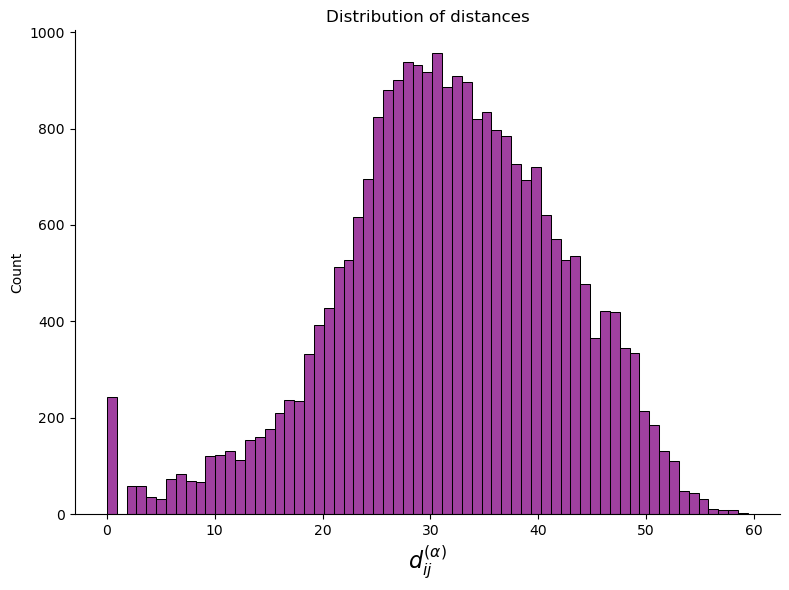

<Figure size 640x480 with 0 Axes>

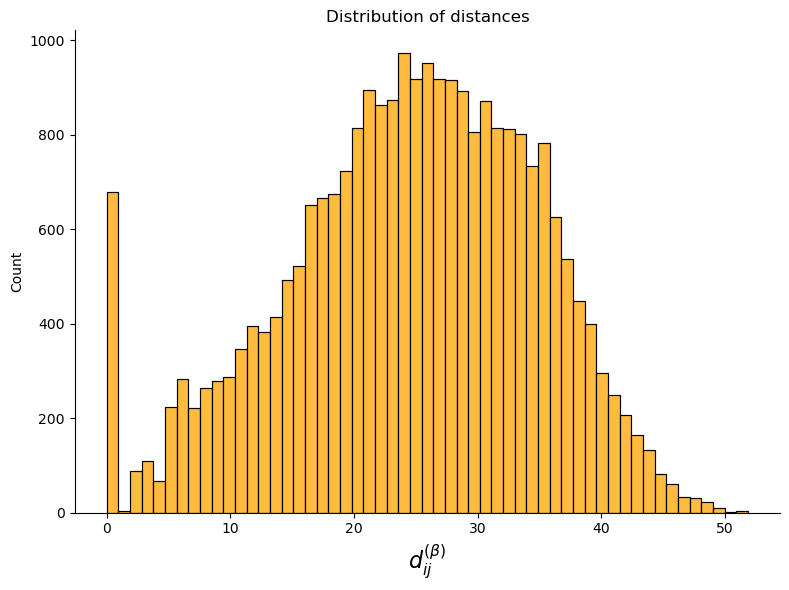

<Figure size 640x480 with 0 Axes>

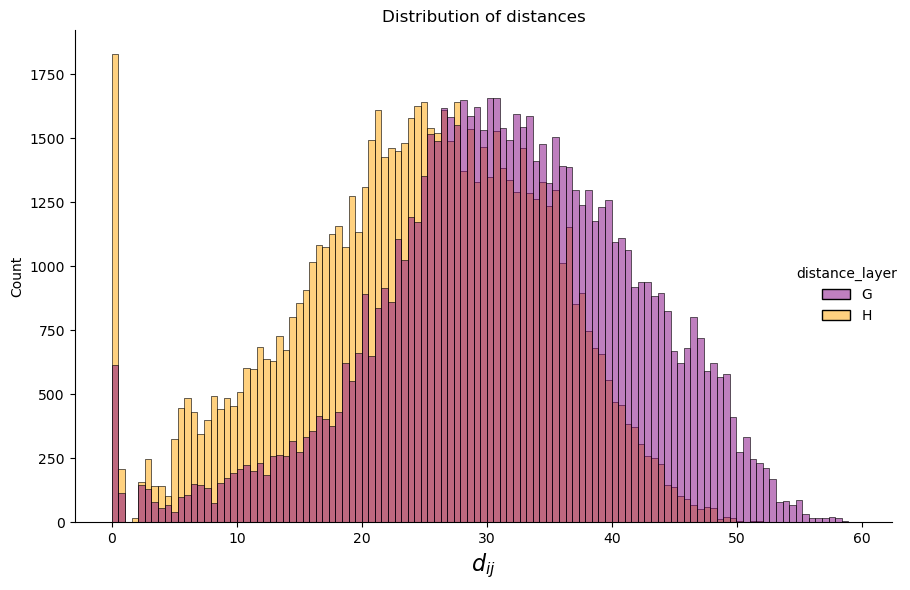

In [373]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="distance_G",
    height=6, aspect=8/6,
    common_norm=True,
    color="purple"
)

# Axes configuration
plt.xlabel("$d_{ij}^{(\\alpha)}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of distances")

# Save plot
plt.tight_layout()

# ===============================================
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="distance_H",
    height=6, aspect=8/6,
    common_norm=True,
    color="orange"
)

# Axes configuration
plt.xlabel("$d_{ij}^{(\\beta)}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of distances")

# Save plot
plt.tight_layout()

# ===============================================
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df_melted, kind="hist",
    x="distance",
    hue="distance_layer", palette=["purple", "orange"],
    height=6, aspect=8/6,
    common_norm=True,
)

# Axes configuration
plt.xlabel("$d_{ij}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of distances")

# Save plot
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

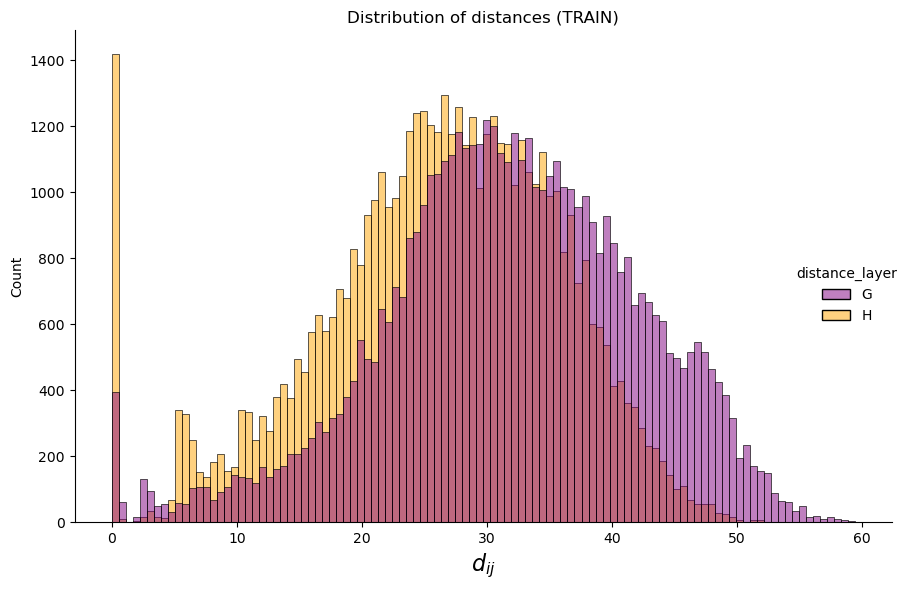

In [374]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df_melted.query("tts == 'Train'"), kind="hist",
    x="distance",
    hue="distance_layer", palette=["purple", "orange"],
    height=6, aspect=8/6,
    common_norm=True,
)

# Axes configuration
plt.xlabel("$d_{ij}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of distances (TRAIN)")

# Save plot
plt.tight_layout()


<Figure size 640x480 with 0 Axes>

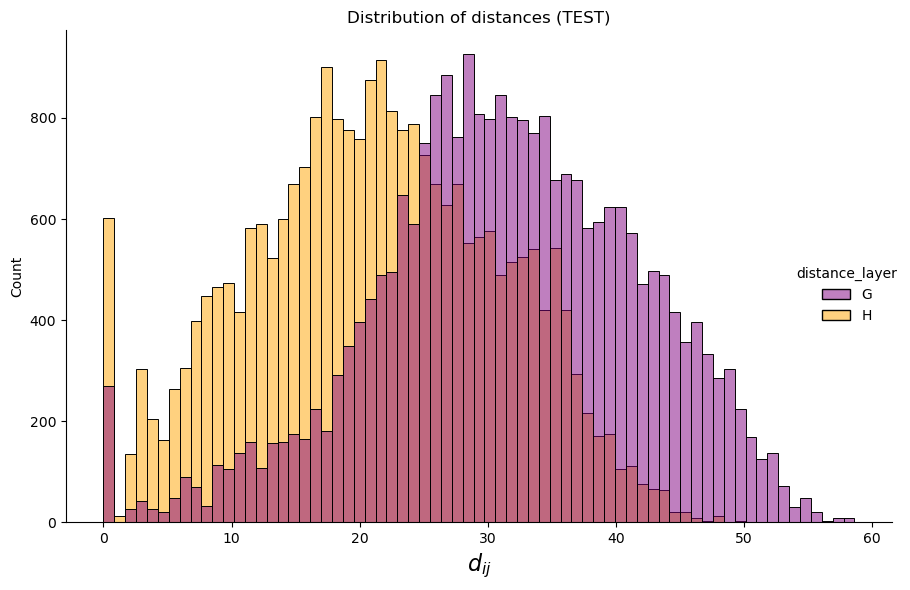

In [375]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df_melted.query("tts == 'Test'"), kind="hist",
    x="distance",
    hue="distance_layer", palette=["purple", "orange"],
    height=6, aspect=8/6,
    common_norm=True,
)

# Axes configuration
plt.xlabel("$d_{ij}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of distances (TEST)")

# Save plot
plt.tight_layout()


<Figure size 640x480 with 0 Axes>

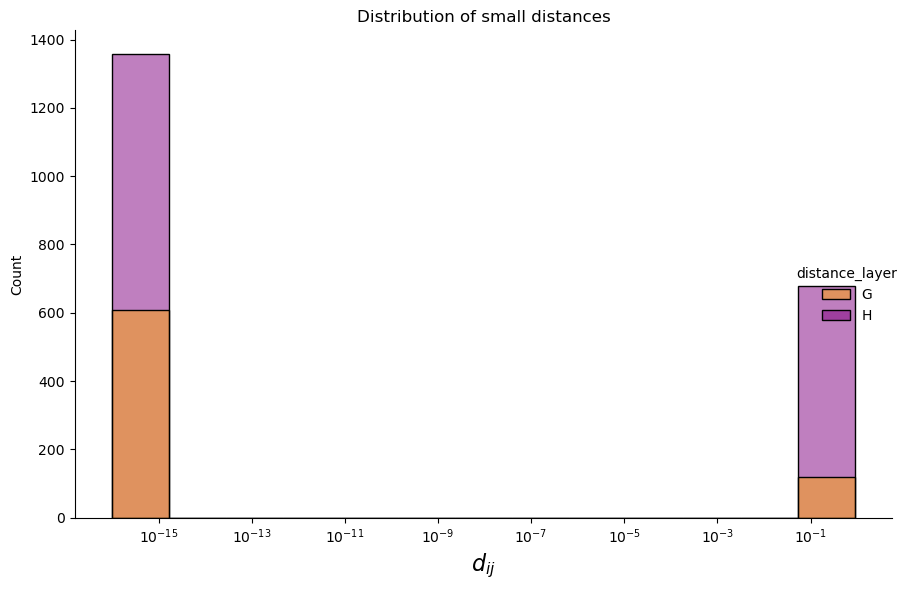

In [376]:
# Instantiate figure, subset relevant data
plt.figure()
df_ = df_melted.query("distance < 1")

# Plotting data
sns.displot(
    data=df_, kind="hist",
    x="distance",
    hue="distance_layer", palette=["orange", "purple"],
    height=6, aspect=8/6,
    common_norm=True,
    log_scale=True
)

# Axes configuration
plt.xlabel("$d_{ij}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of small distances")

# Save plot
plt.tight_layout()


The distribution of distances in each remnant is approximately normal with non-negligible outliers near 0. We will [explore later]() if these are associated with isolated edges or "island" components.

As can be seen from the overlapping histograms, the center of the distributions does appear to be different. We conduct a 2-sample T-test below but mostly for fun, there are like 23,000 degrees of freedom or something obnoxious like that

In [377]:
# Remove small outliers for now
df_ = df_melted.query("distance > 10e-3")  # threshold eye-balled from above

X = df_.query("distance_layer == 'G'")["distance"]
Y = df_.query("distance_layer == 'H'")["distance"]

print(f"d_G variance = {np.var(X):.4f}, d_H variance = {np.var(Y):.4f}")

result = stats.ttest_ind(a=X, b=Y, equal_var=True)
print(result)

test_pass = "CAN" if result.pvalue < 0.05 else "CANNOT"
print(f"Test p-value = {result.pvalue} ===> With alpha = 0.05, we {test_pass} reject the null hypothesis that the two distributions have equal mean.")

d_G variance = 100.9163, d_H variance = 92.7138
Ttest_indResult(statistic=136.76811843039124, pvalue=0.0)
Test p-value = 0.0 ===> With alpha = 0.05, we CAN reject the null hypothesis that the two distributions have equal mean.


#### Bivariate

<Figure size 800x600 with 0 Axes>

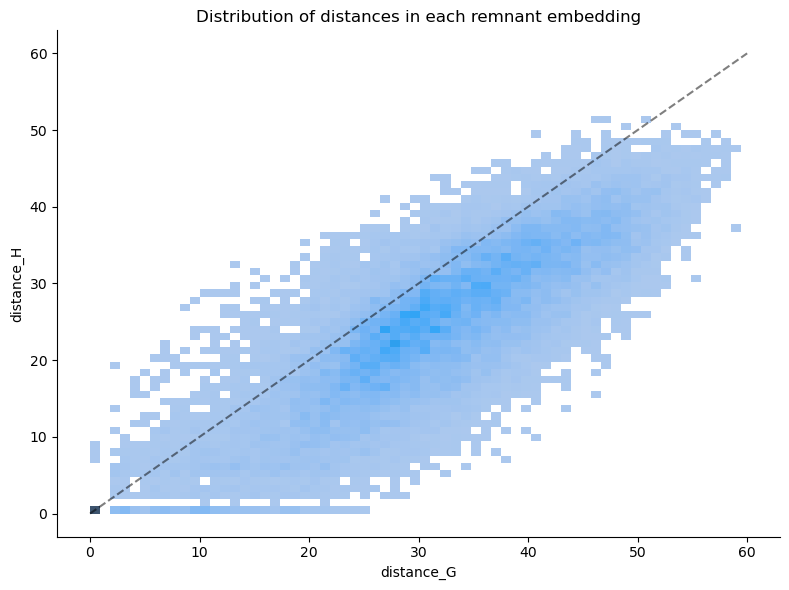

<Figure size 800x600 with 0 Axes>

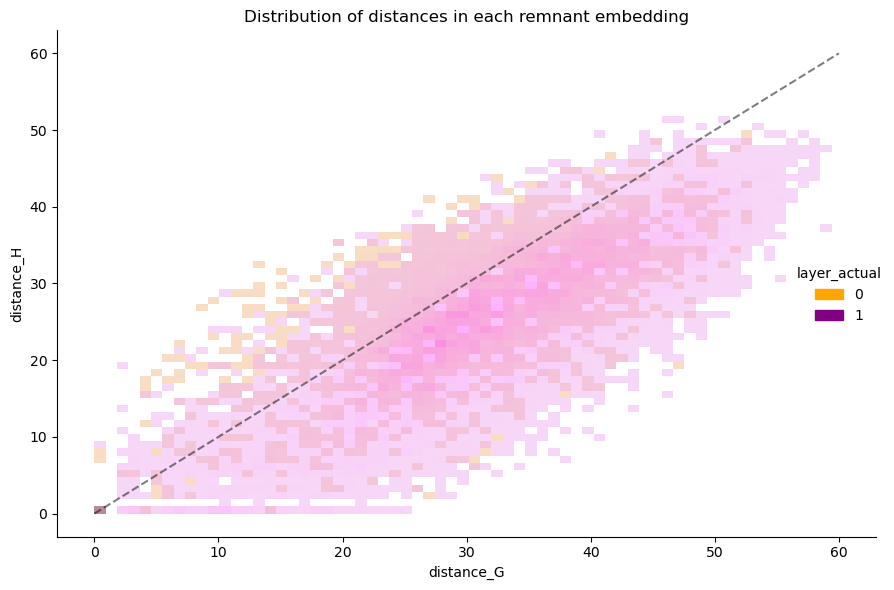

<Figure size 800x600 with 0 Axes>

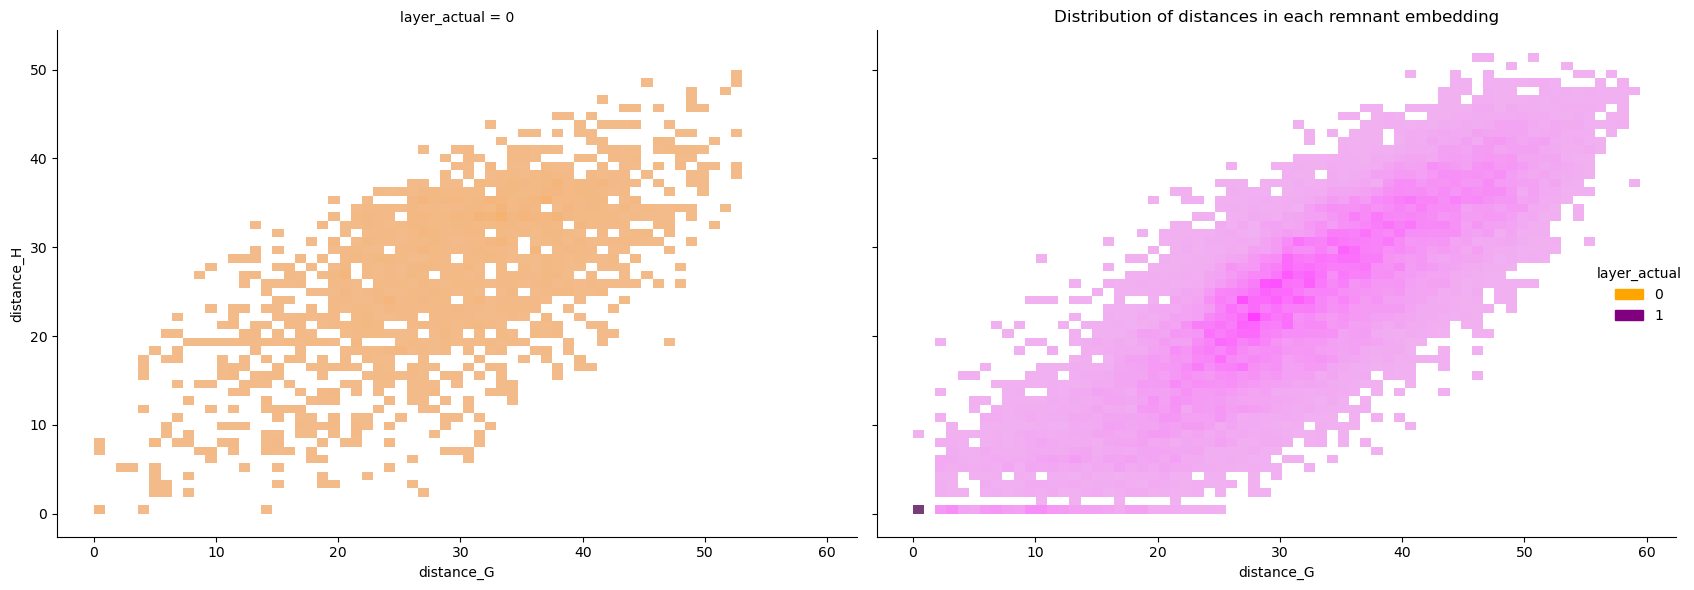

In [378]:
# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="distance_G", y="distance_H",
    height=6, aspect=8/6,
)
id_line = np.linspace(0,60)
plt.plot(id_line, id_line, linestyle="--", color="black", alpha=0.5)

# Figure-level attributes
plt.title("Distribution of distances in each remnant embedding")

# Save plot
plt.tight_layout()

# ===================================================================

# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="distance_G", y="distance_H",
    hue="layer_actual", palette=["orange", "purple"],
    # col="layer_actual",
    height=6, aspect=8/6,
    alpha=0.5
)
plt.plot(id_line, id_line, linestyle="--", color="black", alpha=0.5)

# Figure-level attributes
plt.title("Distribution of distances in each remnant embedding")

# Save plot
plt.tight_layout()

# ===================================================================

# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="distance_G", y="distance_H",
    hue="layer_actual", palette=["orange", "purple"],
    col="layer_actual",
    height=6, aspect=8/6,
)

# Figure-level attributes
plt.title("Distribution of distances in each remnant embedding")

# Save plot
plt.tight_layout()


With the simplest embedding information (raw distance per layer) as above, the layers do not appear to be particularly separable. In fact, with these quantities the entirety of classification performance seems, by eye, to due to class imbalance. The absolute sizes of the classes is given below.

In [379]:
class_sizes = df["layer_actual"].value_counts()

print(f"G contains {100*(class_sizes.iloc[0] / len(df)):.0f}% of all edges")

G contains 93% of all edges


### Features

<Figure size 640x480 with 0 Axes>

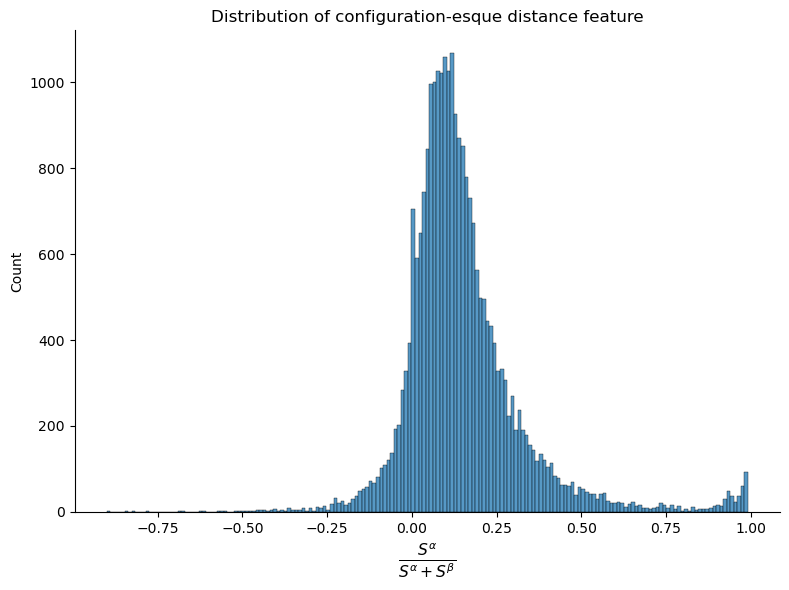

<Figure size 640x480 with 0 Axes>

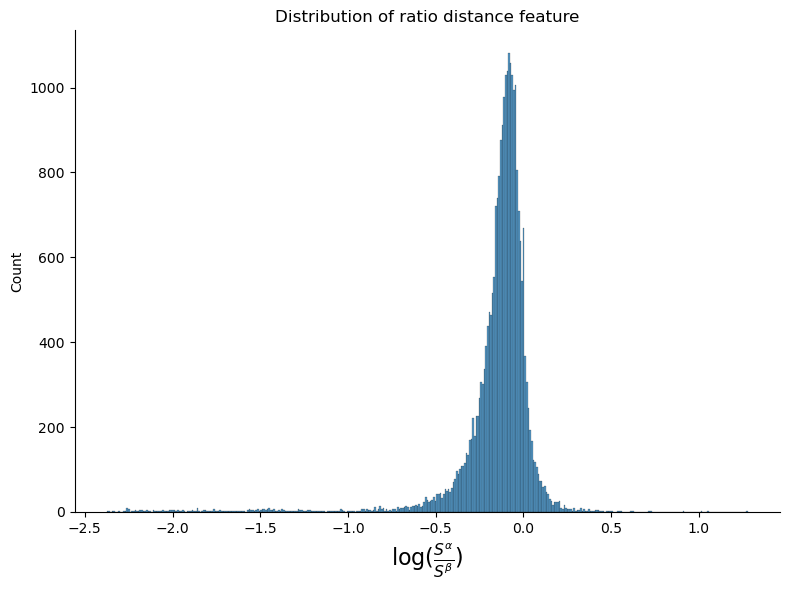

In [380]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="feature_c",
    height=6, aspect=8/6,
    common_norm=True
)

# Axes configuration
plt.xlabel("$\\frac{S^{\\alpha}}{S^{\\alpha} + S^{\\beta}}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of configuration-esque distance feature")

# Save plot
plt.tight_layout()

# =======================================================

# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df.loc[abs(df["log_ratio"]) < 5], kind="hist",
    x="log_ratio",
    height=6, aspect=8/6,
)

# Axes configuration
plt.xlabel("$\\log(\\frac{S^{\\alpha}}{S^{\\beta}})$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of ratio distance feature")

# Save plot
plt.tight_layout()
# plt.savefig(f"../../results/plots/line_aupr-pfi_imb-emb-deg_{TAG}.png", facecolor="white", transparent=False)

<Figure size 640x480 with 0 Axes>

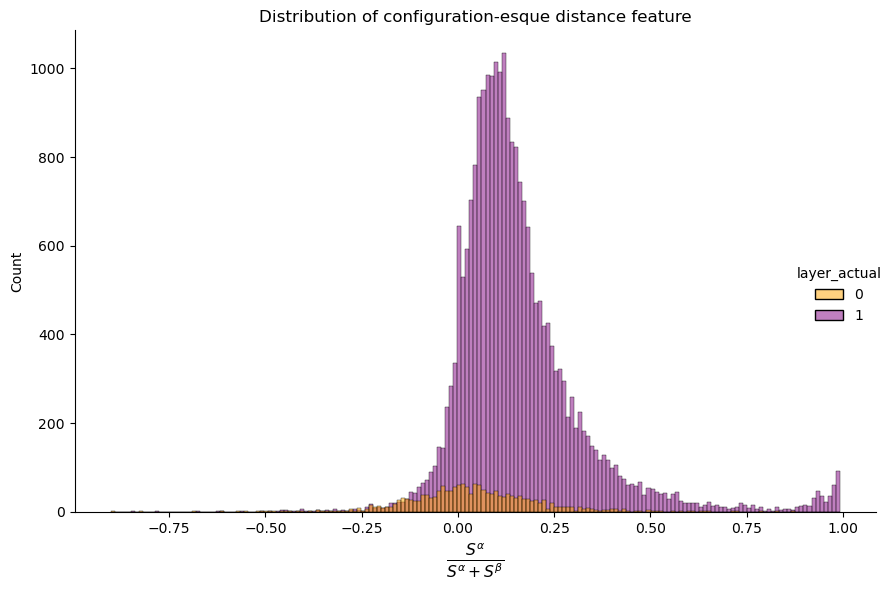

<Figure size 640x480 with 0 Axes>

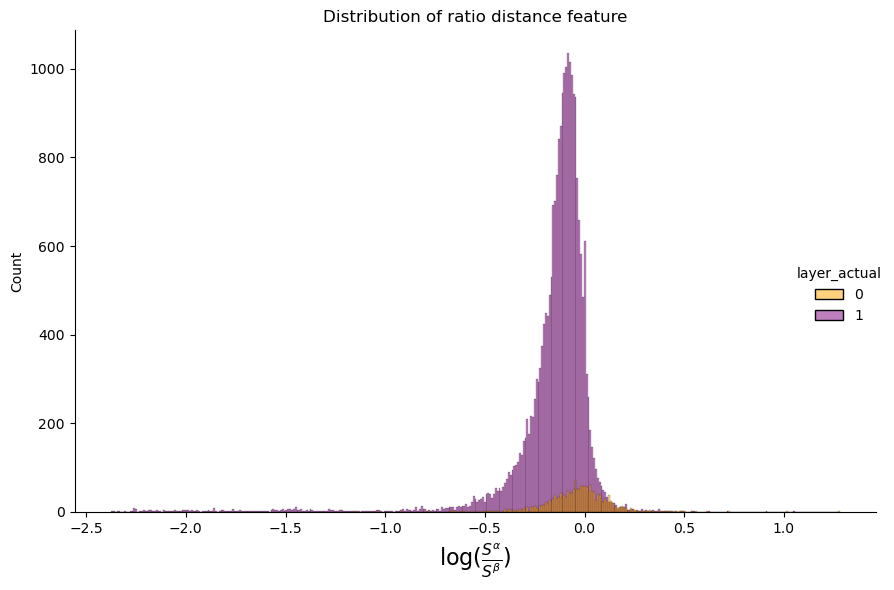

In [381]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="feature_c",
    hue="layer_actual", palette=["orange", "purple"],
    height=6, aspect=8/6,
    common_norm=True
)

# Axes configuration
plt.xlabel("$\\frac{S^{\\alpha}}{S^{\\alpha} + S^{\\beta}}$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of configuration-esque distance feature")

# Save plot
plt.tight_layout()

# =======================================================

# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df.loc[abs(df["log_ratio"]) < 5], kind="hist",
    x="log_ratio",
    hue="layer_actual", palette=["orange", "purple"],
    height=6, aspect=8/6,
)

# Axes configuration
plt.xlabel("$\\log(\\frac{S^{\\alpha}}{S^{\\beta}})$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of ratio distance feature")

# Save plot
plt.tight_layout()

<Figure size 800x600 with 0 Axes>

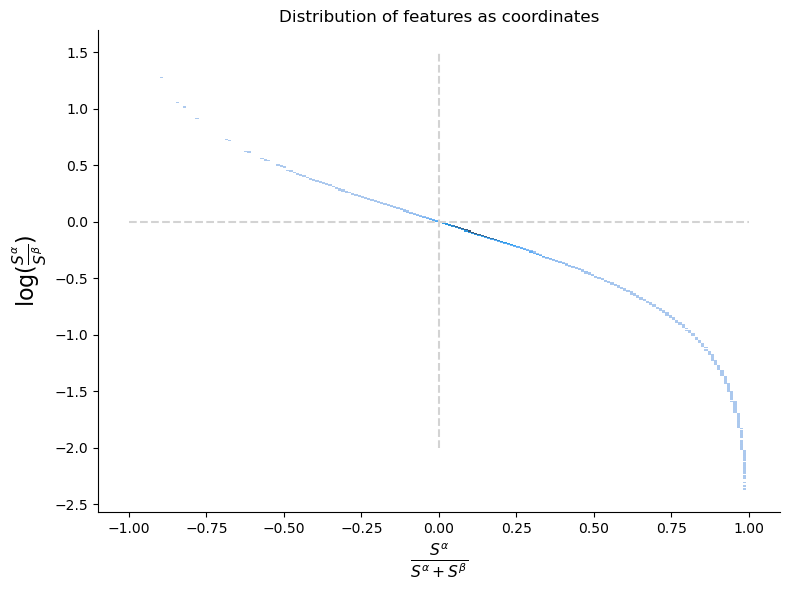

In [382]:
# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
sns.displot(
    data=df.loc[abs(df["log_ratio"]) < 5], kind="hist",
    x="feature_c", y="log_ratio",
    height=6, aspect=8/6,
)
plt.hlines(0, -1, 1, linestyle="--", color="lightgray")
plt.vlines(0, -2, 1.5, linestyle="--", color="lightgray")

# Axes configuration
plt.xlabel("$\\frac{S^{\\alpha}}{S^{\\alpha} + S^{\\beta}}$", fontdict={"size": 16})
plt.ylabel("$\\log(\\frac{S^{\\alpha}}{S^{\\beta}})$", fontdict={"size": 16})

# Figure-level attributes
plt.title("Distribution of features as coordinates")

# Save plot
plt.tight_layout()

## Class separability

<Figure size 640x480 with 0 Axes>

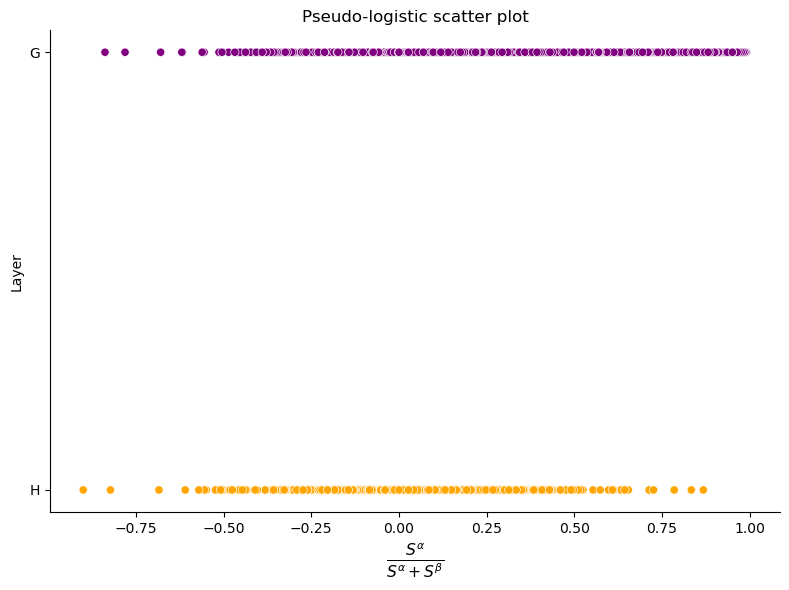

<Figure size 640x480 with 0 Axes>

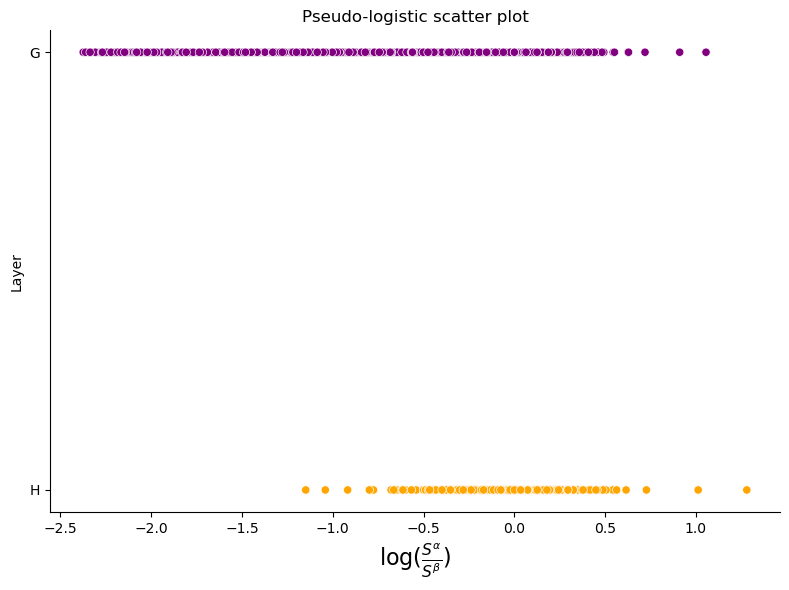

In [383]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.relplot(
    data=df, kind="scatter",
    x="feature_c", y="layer_actual",
    hue="layer_actual", palette=["orange", "purple"],
    legend=False,
    height=6, aspect=8/6
)

# Axes configuration
plt.xlabel("$\\frac{S^{\\alpha}}{S^{\\alpha} + S^{\\beta}}$", fontdict={"size": 16})

plt.ylabel("Layer")
plt.yticks([0, 1], labels=["H", "G"])

# Figure-level attributes
plt.title("Pseudo-logistic scatter plot")

# Save plot
plt.tight_layout()

# ==============================================================

# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.relplot(
    data=df.loc[abs(df["log_ratio"]) < 5], kind="scatter",
    x="log_ratio", y="layer_actual",
    hue="layer_actual", palette=["orange", "purple"],
    legend=False,
    height=6, aspect=8/6
)

# Axes configuration
plt.xlabel("$\\log(\\frac{S^{\\alpha}}{S^{\\beta}})$", fontdict={"size": 16})

plt.ylabel("Layer")
plt.yticks([0, 1], labels=["H", "G"])

# Figure-level attributes
plt.title("Pseudo-logistic scatter plot")

# Save plot
plt.tight_layout()


<Figure size 800x600 with 0 Axes>

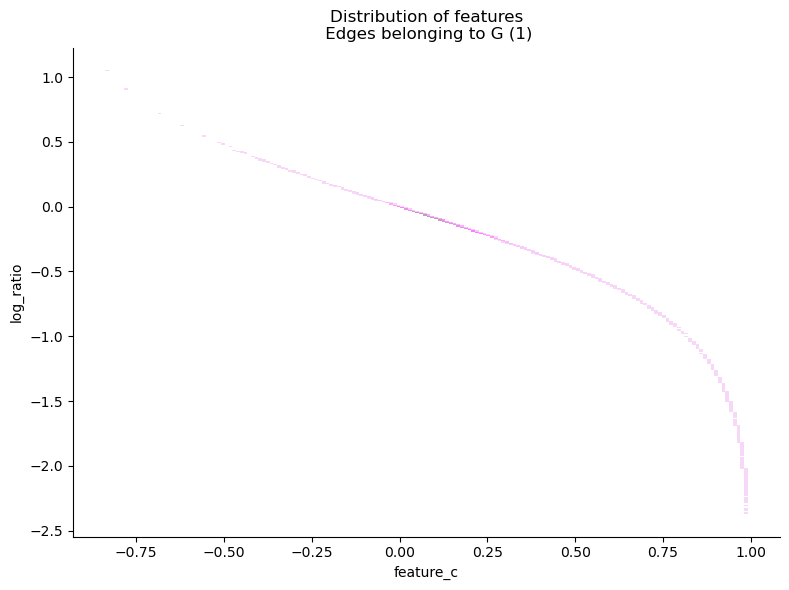

<Figure size 800x600 with 0 Axes>

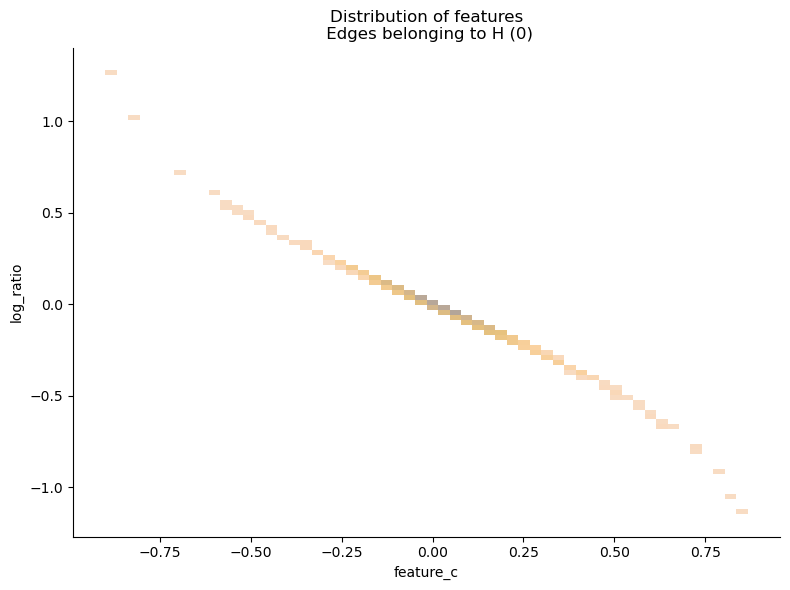

<Figure size 800x600 with 0 Axes>

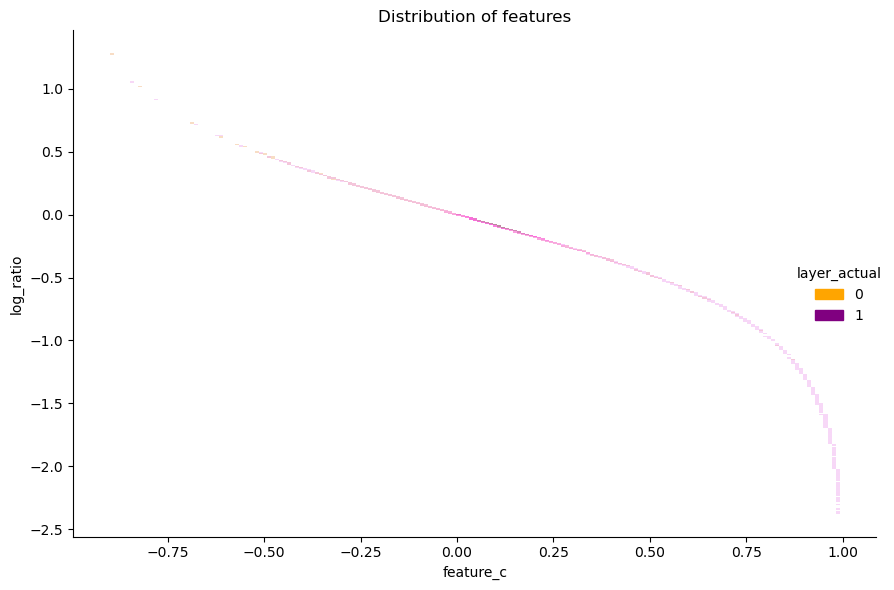

In [384]:
# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
sns.displot(
    data=df.loc[(abs(df["log_ratio"]) < 5) & (df["layer_actual"] == 1)], kind="hist",
    x="feature_c", y="log_ratio",
    color="purple",
    height=6, aspect=8/6,
    alpha=0.5
)

# Figure-level attributes
plt.title("Distribution of features\n Edges belonging to G (1)")

# Save plot
plt.tight_layout()

# ================================================================

# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
sns.displot(
    data=df.loc[(abs(df["log_ratio"]) < 5) & (df["layer_actual"] == 0)], kind="hist",
    x="feature_c", y="log_ratio",
    color="orange",
    height=6, aspect=8/6,
    alpha=0.5
)

# Figure-level attributes
plt.title("Distribution of features\n Edges belonging to H (0)")

# Save plot
plt.tight_layout()

# ================================================================

# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
sns.displot(
    data=df.loc[abs(df["log_ratio"]) < 5], kind="hist",
    x="feature_c", y="log_ratio",
    hue="layer_actual", palette=["orange", "purple"],
    height=6, aspect=8/6,
    alpha=0.5
)

# Figure-level attributes
plt.title("Distribution of features")

# Save plot
plt.tight_layout()

## Logistic regression models

In [385]:
df_train = df.query("tts == 'Train'")
df_test = df.query("tts == 'Test'")

In [386]:
Y_train = df_train["layer_actual"]
Y_test = df_test["layer_actual"]

### Configuration feature

In [387]:
X_train = df_train["feature_c"].to_numpy().reshape(-1,1)
X_test = df_test["feature_c"].to_numpy().reshape(-1,1)

In [388]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

In [389]:
print(f"Simple score: {model.score(X_test, Y_test):.4f}")

Simple score: 0.9279


Note that the simple score very closely matches the [layer imbalance](#bivariate)

<Figure size 640x480 with 0 Axes>

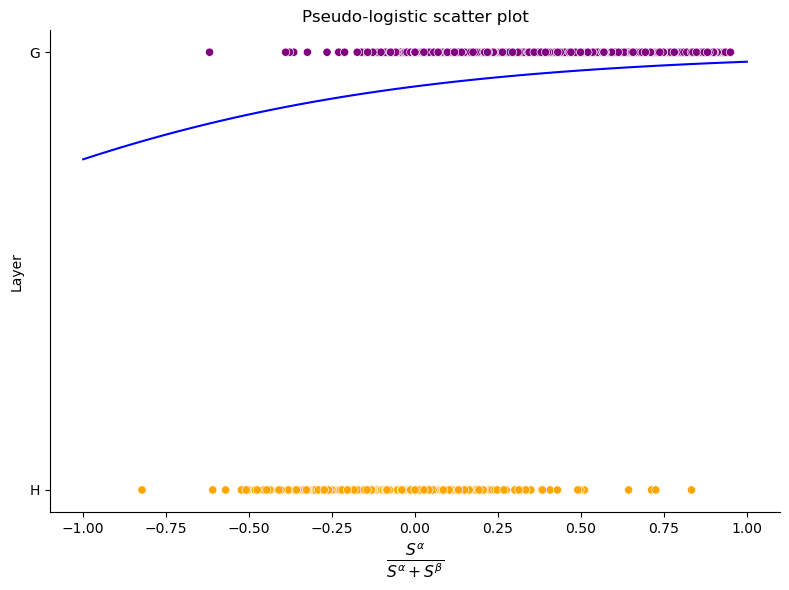

In [390]:
# Instantiate figure, subset relevant data
plt.figure()
X = np.linspace(-1,1)
Y = model.predict_proba(X.reshape(-1,1))[:, 1]

# Plotting data
sns.relplot(
    data=df_test, kind="scatter",
    x="feature_c", y="layer_actual",
    hue="layer_actual", palette=["orange", "purple"],
    legend=False,
    height=6, aspect=8/6
)
plt.plot(X, Y, color="blue")

# Axes configuration
plt.xlabel("$\\frac{S^{\\alpha}}{S^{\\alpha} + S^{\\beta}}$", fontdict={"size": 16})

plt.ylabel("Layer")
plt.yticks([0, 1], labels=["H", "G"])

# Figure-level attributes
plt.title("Pseudo-logistic scatter plot")

# Save plot
plt.tight_layout()

In [391]:
# plt.figure(figsize=(8,8))

# plt.plot(roc_curve(model, X_test))

# plt.legend()
# plt.title("ROC Curve\n Configuration Feature")

# plt.figure(figsize=(8,8))

# plt.plot(precision_recall_curve(model, X_test))

# plt.legend()
# plt.title("Precision-Recall Curve\n Configuration Feature")

In [392]:
# plt.figure(figsize=(8,8))

# plot_roc_curve(model, -1*X_test, Y_test)

# plt.legend()
# plt.title("ROC Curve\n Negated Configuration Feature")

# plt.figure(figsize=(8,8))

# plot_precision_recall_curve(model, -1*X_test, Y_test)

# plt.legend()
# plt.title("Precision-Recall Curve\n Negated Configuration Feature")

### Ratio feature

In [393]:
X_train = df_train["log_ratio"].to_numpy().reshape(-1,1)
X_test = df_test["log_ratio"].to_numpy().reshape(-1,1)

In [394]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

<Figure size 640x480 with 0 Axes>

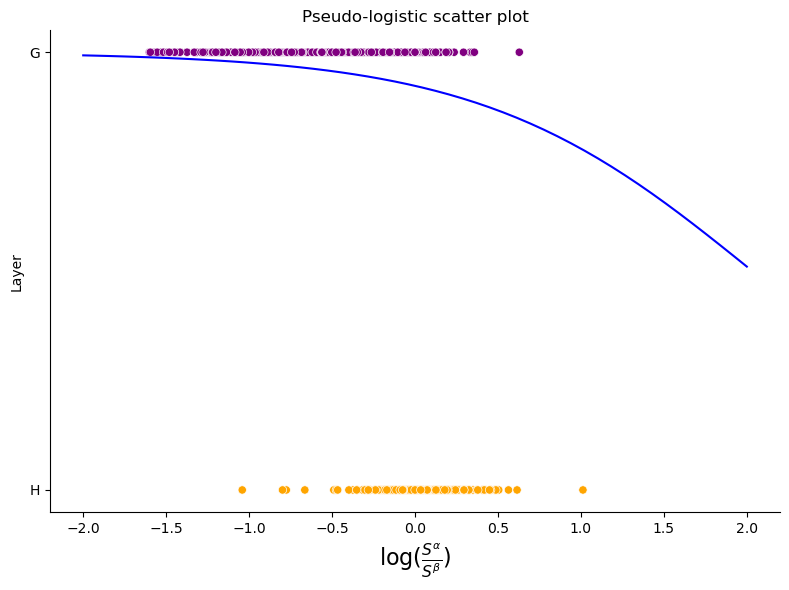

In [395]:
# Instantiate figure, subset relevant data
plt.figure()
X = np.linspace(-2,2)
Y = model.predict_proba(X.reshape(-1,1))[:, 1]

# Plotting data
sns.relplot(
    data=df_test.loc[abs(df_test["log_ratio"]) < 5], kind="scatter",
    x="log_ratio", y="layer_actual",
    hue="layer_actual", palette=["orange", "purple"],
    legend=False,
    height=6, aspect=8/6
)
plt.plot(X, Y, color="blue")

# Axes configuration
plt.xlabel("$\\log(\\frac{S^{\\alpha}}{S^{\\beta}})$", fontdict={"size": 16})

plt.ylabel("Layer")
plt.yticks([0, 1], labels=["H", "G"])

# Figure-level attributes
plt.title("Pseudo-logistic scatter plot")

# Save plot
plt.tight_layout()

In [396]:
# plt.figure(figsize=(8,8))

# plot_roc_curve(model, X_test, Y_test)

# plt.legend()
# plt.title("ROC Curve\n Log Ratio Feature")

# plt.figure(figsize=(8,8))

# plot_precision_recall_curve(model, X_test, Y_test)

# plt.legend()
# plt.title("Precision-recall Curve\n Log Ratio Feature")

In [397]:
# plt.figure(figsize=(8,8))

# plot_roc_curve(model, -1*X_test, Y_test)

# plt.legend()
# plt.title("ROC Curve\n Negated Log Ratio Feature")

# plt.figure(figsize=(8,8))

# plot_precision_recall_curve(model, -1*X_test, Y_test)

# plt.legend()
# plt.title("Precision-recall Curve\n Negated Log Ratio Feature")

## Model similarities

In [398]:
model_config = LogisticRegression()
model_config.fit(
    df_train["feature_c"].to_numpy().reshape(-1,1),
    Y_train
)

model_ratio = LogisticRegression()
model_ratio.fit(
    df_train["log_ratio"].to_numpy().reshape(-1,1),
    Y_train
)

LogisticRegression()

In [399]:
print(
    f"Configuration model : Intercept = {model_config.intercept_[0]:.4f}; Coefficient = {model_config.coef_[0][0]:.4f}"
)
print(
    f"Ratio model : Intercept = {model_ratio.intercept_[0]:.4f}; Coefficient = {model_ratio.coef_[0][0]:.4f}"
)

Configuration model : Intercept = 2.4679; Coefficient = 1.3403
Ratio model : Intercept = 2.4866; Coefficient = -1.2227


In [400]:
def model_config_(x):
    f = model_config.intercept_[0] + model_config.coef_[0][0]*x
    return 1 / (1 + np.exp(-f))

def model_ratio_(x):
    f = model_ratio.intercept_[0] + model_ratio.coef_[0][0]*x
    return 1 / (1 + np.exp(-f))

Text(0.5, 1.0, 'Comparing trained models with feature negation')

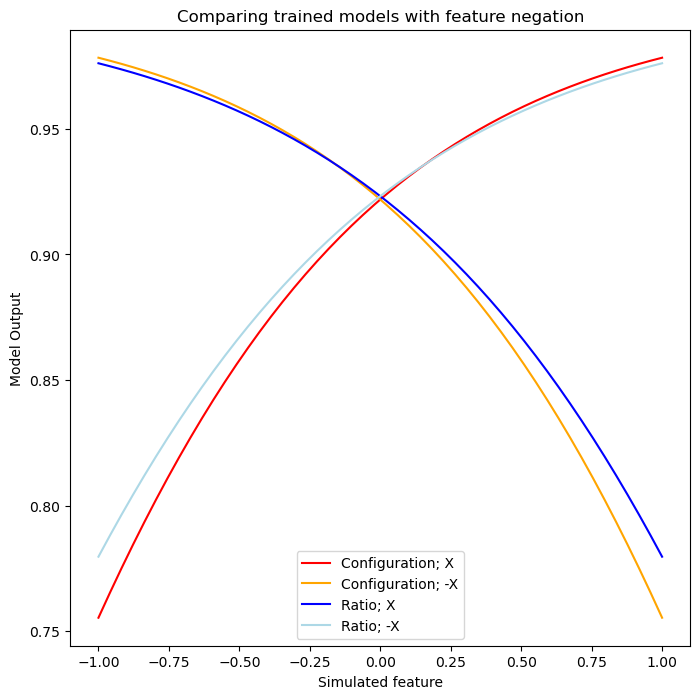

In [401]:
X = np.linspace(-1,1)
plt.figure(figsize=(8,8))

plt.plot(X, [model_config_(x) for x in X], label="Configuration; X", color="red")
plt.plot(X, [model_config_(-x) for x in X], label="Configuration; -X", color="orange")
plt.plot(X, [model_ratio_(x) for x in X], label="Ratio; X", color="blue")
plt.plot(X, [model_ratio_(-x) for x in X], label="Ratio; -X", color="lightblue")

plt.legend()
plt.xlabel("Simulated feature")
plt.ylabel("Model Output")

plt.title("Comparing trained models with feature negation")

In [402]:
def threshold_scores(Y, t):
    return [1 if y >= t else 0 for y in Y]

In [403]:
Y = [model_config_(y) for y in df_test["feature_c"].to_numpy().reshape(-1,1)]
precisions = np.linspace(0.9,1)

accuracy_curve = [
    accuracy_score(df_test["layer_actual"], threshold_scores(Y, p))
    for p in precisions
]
precision_curve = [
    precision_score(df_test["layer_actual"], threshold_scores(Y, p))
    for p in precisions
]
recall_curve = [
    recall_score(df_test["layer_actual"], threshold_scores(Y, p))
    for p in precisions
]

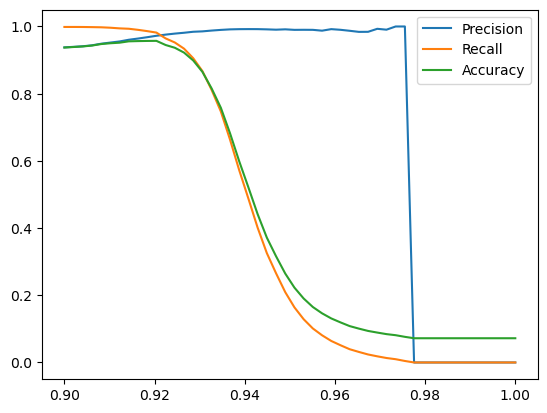

In [404]:
plt.plot(precisions, precision_curve, label="Precision")
plt.plot(precisions, recall_curve, label="Recall")
plt.plot(precisions, accuracy_curve, label="Accuracy")
plt.legend()

## TTS Visualizations

<Figure size 800x600 with 0 Axes>

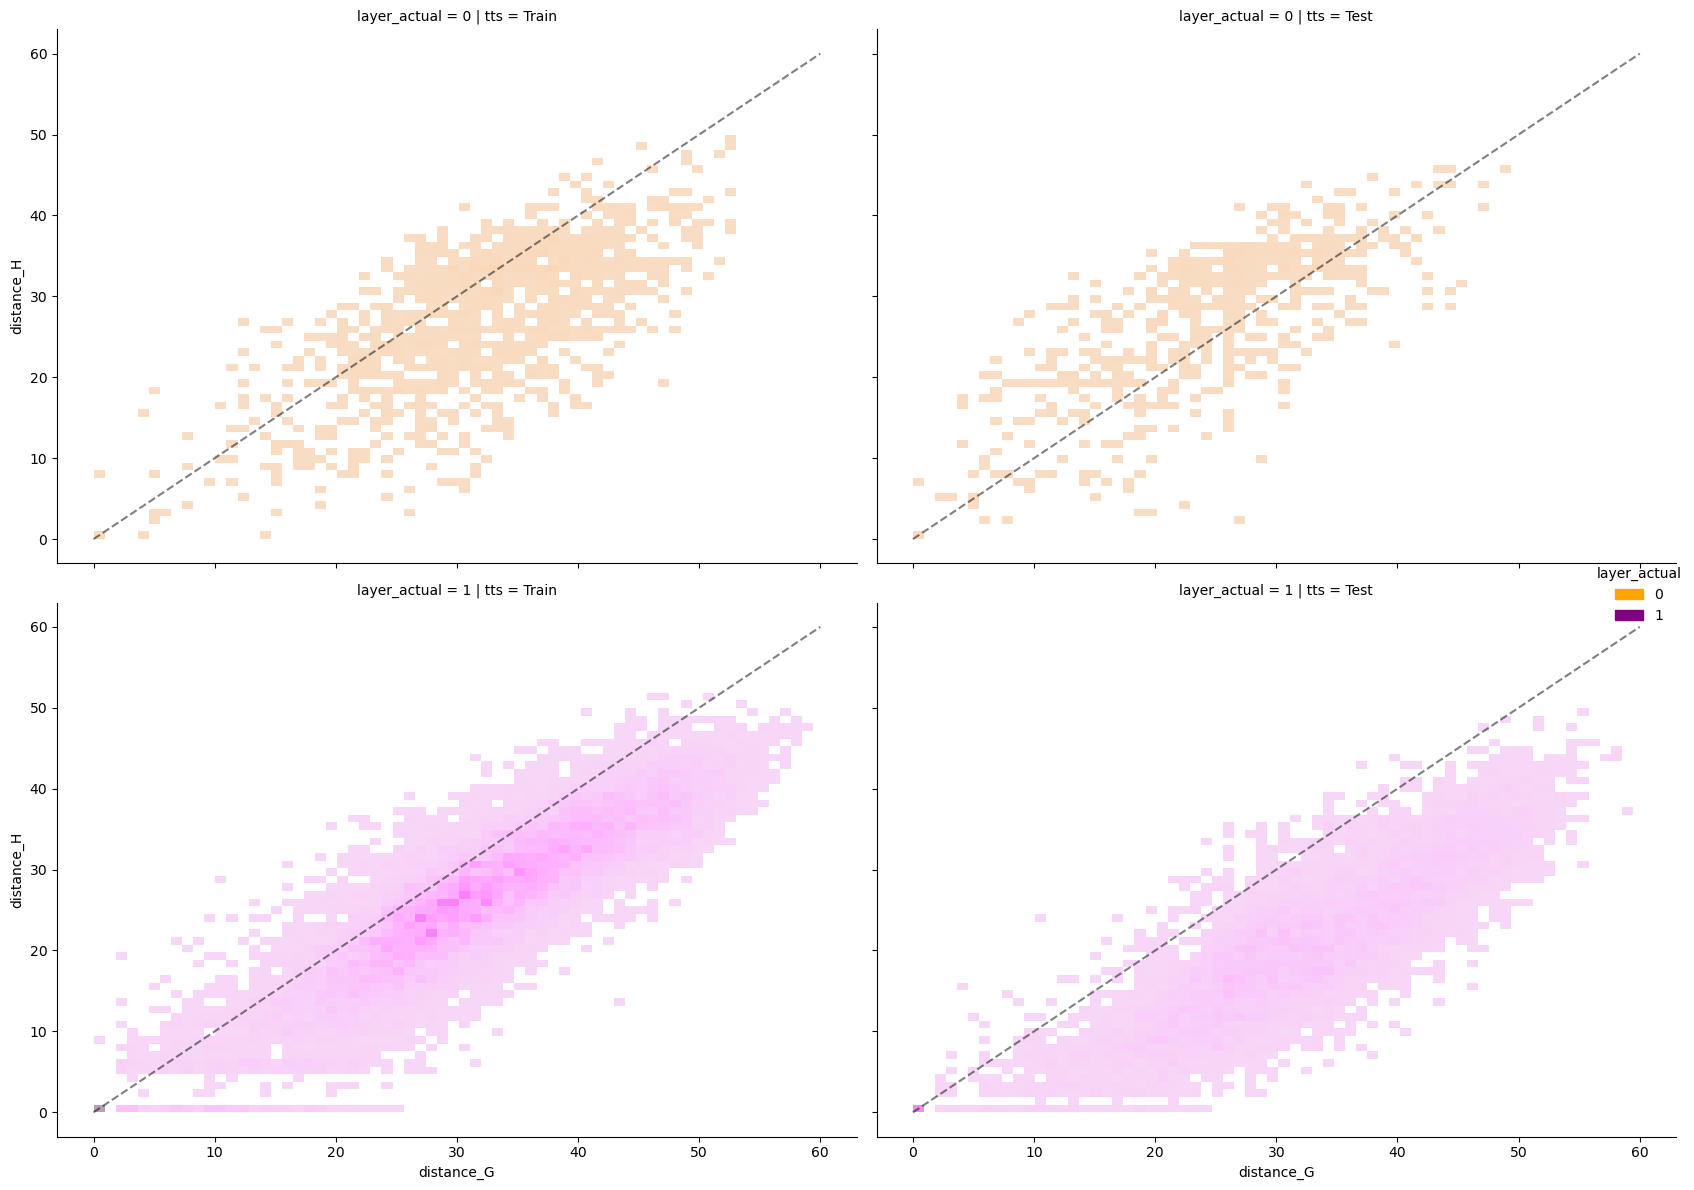

In [405]:
# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
g = sns.displot(
    data=df, kind="hist",
    x="distance_G", y="distance_H",
    hue="layer_actual", palette=["orange", "purple"],
    col="tts", row="layer_actual",
    height=6, aspect=8/6,
    alpha=0.5
)
for ax in g.axes.flat:
    ax.plot(id_line, id_line, linestyle="--", color="black", alpha=0.5)

# Save plot
plt.tight_layout()

<Figure size 800x600 with 0 Axes>

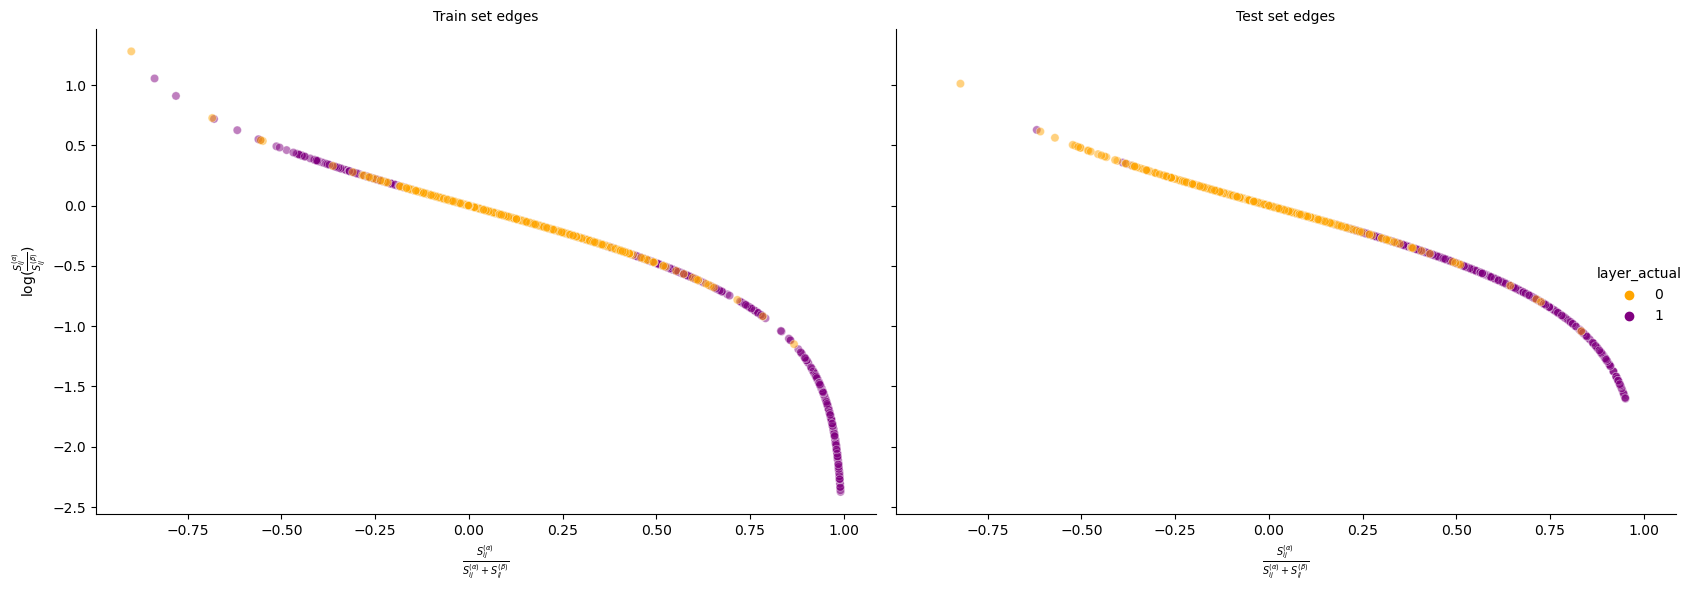

In [406]:
# Instantiate figure, subset relevant data
plt.figure(figsize=(8,6))

# Plotting data
g = sns.relplot(
    data=df.loc[abs(df["log_ratio"]) < 5], kind="scatter",
    x="feature_c", y="log_ratio",
    col="tts",
    hue="layer_actual", palette=["orange", "purple"],
    height=6, aspect=8/6,
    alpha=0.5,
)
g.set_axis_labels(
    "$\\frac{S_{ij}^{(\\alpha)}}{S_{ij}^{(\\alpha)} + S_{ij}^{(\\beta)}}$",
    "$\\log(\\frac{S_{ij}^{(\\alpha)}}{S_{ij}^{(\\beta)}})$"
)
g.set_titles("{col_name} set edges")

# Figure-level attributes
# plt.title("Distribution of training set features")

# Save plot
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

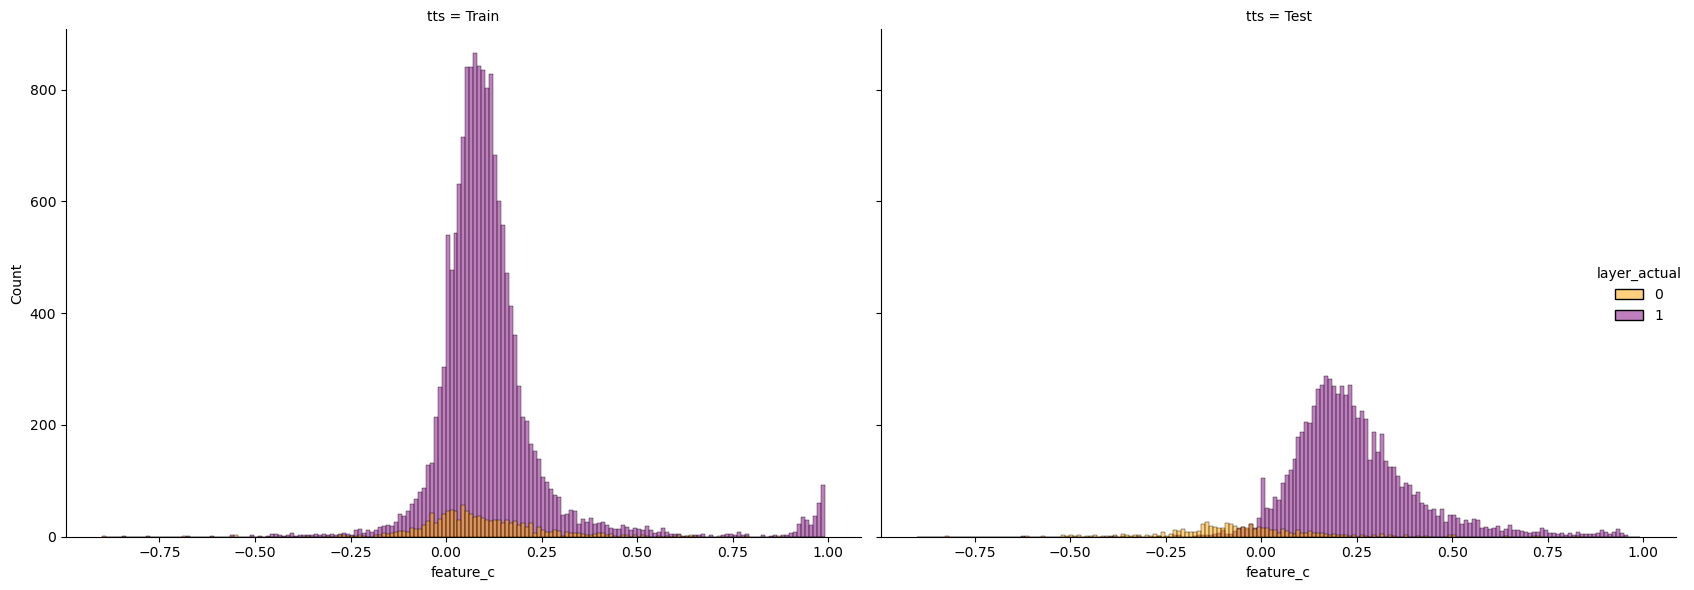

In [407]:
# Instantiate figure, subset relevant data
plt.figure()

# Plotting data
sns.displot(
    data=df, kind="hist",
    x="feature_c",
    col="tts",
    hue="layer_actual", palette=["orange", "purple"],
    height=6, aspect=8/6,
    common_norm=True
)

# Axes configuration
# plt.xlabel("$\\frac{S^{\\alpha}}{S^{\\alpha} + S^{\\beta}}$", fontdict={"size": 16})

# Figure-level attributes
# plt.title("Distribution of configuration-esque distance feature")

# Save plot
plt.tight_layout()

# Network analysis

In [408]:
records = []
for THETA in THETAS:
    cache = get_preprocessed_data(SYSTEM, LAYERS, THETA, REP)

    GCCs = []
    sizes_ = []
    for layer in cache.remnants:
        comps = [
            list(component)
            for component in nx.connected_components(layer)
        ]
        comps = sorted(comps, key=len, reverse=True)
        sizes = [len(x) for x in comps]
        normalize_ = sum(sizes)
        sizes = np.array(sizes) / normalize_

        sizes_.append(sizes)
        GCCs.append(sizes[0])

    records.append({
        "theta": THETA,
        "G_GCC": GCCs[0],
        "H_GCC": GCCs[1],
        "G_sizes": sizes_[0],
        "H_sizes": sizes_[1],
    })

df = pd.DataFrame.from_records(records)

gcc = df.melt(id_vars=["theta"], value_vars=["G_GCC", "H_GCC"], var_name="layer", value_name="GCC").replace({"G_GCC": "G", "H_GCC": "H"})
sizes = df.melt(id_vars=["theta"], value_vars=["G_sizes", "H_sizes"], var_name = "layer", value_name="sizes").replace({"G_sizes": "G", "H_sizes": "H"})

df = gcc.merge(sizes, on=["theta", "layer"])

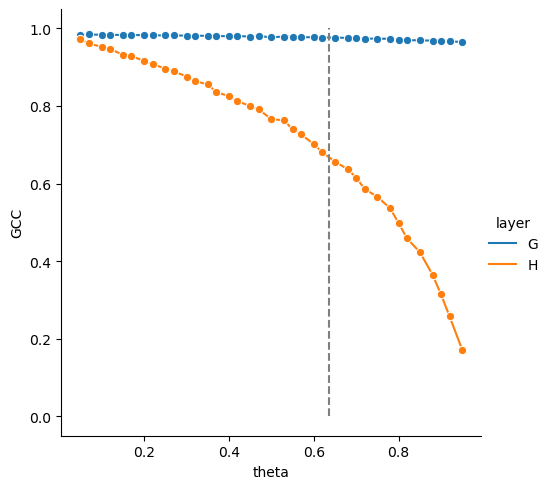

In [409]:
sns.relplot(
    data=df, kind="line",
    x="theta", y="GCC",
    hue="layer", marker="o"
)

plt.vlines(np.mean([0.59, 0.68]), 0, 1, linestyle="--", color="gray")

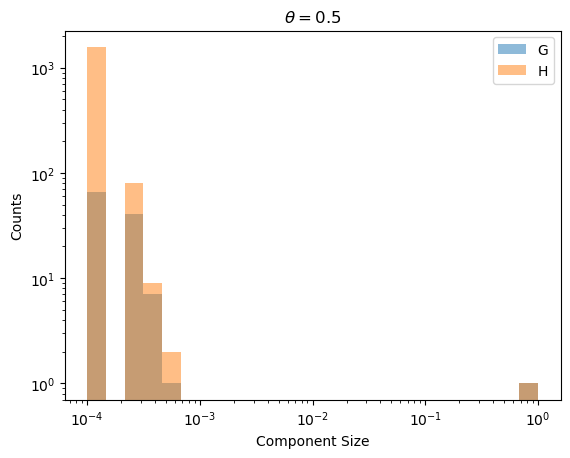

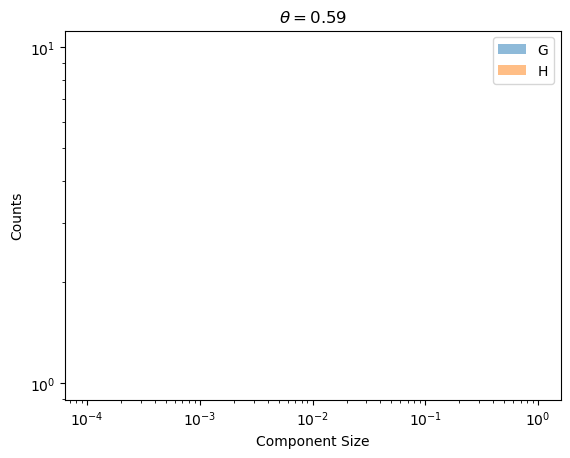

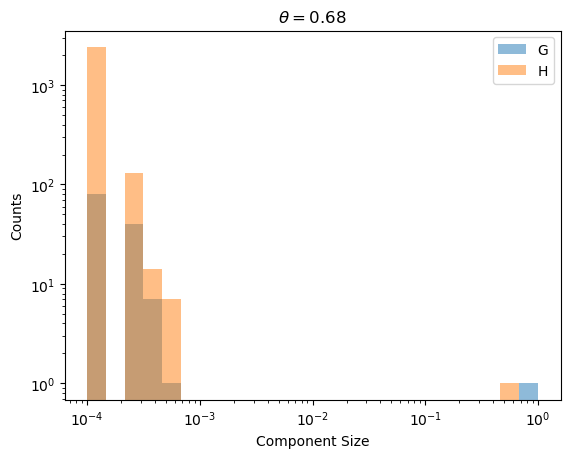

In [410]:
logbins=np.logspace(-4, 0, 25)
for theta in [0.5, 0.59, 0.68]:
    df_ = df.query("theta == @theta")

    plt.figure()
    plt.hist(df_.loc[df_.layer == "G"]["sizes"], bins=logbins, label="G", alpha=0.5)  #, histtype="step", cumulative=-1)
    plt.hist(df_.loc[df_.layer == "H"]["sizes"], bins=logbins, label="H", alpha=0.5)  #, histtype="step", cumulative=-1)
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Component Size")
    plt.ylabel("Counts")
    plt.title(f"$\\theta = {theta}$")

# Detailed logistic regression

## Retraining models

In [411]:
def preprocess_dataframe(SYSTEM, LAYERS, THETA, REP):
    cache = get_preprocessed_data(SYSTEM, LAYERS, THETA, REP)
    cache.embeddings = cache.renormalize()
    cache.embeddings = cache.align_centers()

    edges = cache.observed_edges.copy()
    edges.update(cache.unobserved_edges)

    distances_G, distances_H = get_distances(cache.embeddings, edges.keys())
    feature_c = get_configuration_distances_feature(distances_G, distances_H, zde_penalty=0.1)
    feature_r = get_distance_ratios_feature(distances_G, distances_H, zde_penalty=0.1)

    degrees_G, degrees_H = get_degrees(cache.remnants, edges.keys())
    feature_d = get_configuration_probabilities_feature(degrees_G, degrees_H)

    df = pd.DataFrame({
        "theta": [THETA]*len(edges),
        "edge": edges.keys(),
        "layer_actual": edges.values(),
        "distance_G": distances_G,
        "distance_H": distances_H,
        "feature_c": feature_c,
        "feature_r": feature_r,
        "feature_d": feature_d
    })

    # Adding useful transformation for unbounded feature
    df["log_ratio"] = df["feature_r"].transform(np.log10)

    # Notating TTS
    df["tts"] = [
        "Train" if row[1]["edge"] in cache.observed_edges else "Test"
        for row in df.iterrows()
    ]

    return df

def melt_dataframe(df):
    # Melting main quantitative variables
    df_melted = df.melt(
        id_vars=["theta", "edge", "layer_actual", "distance_G", "distance_H"],
        value_vars=["feature_d", "feature_c", "feature_r", "log_ratio"],
        var_name="feature_type", value_name="feature_value"
    )
    df_melted = df_melted.melt(
        id_vars=["theta", "edge", "layer_actual", "feature_type", "feature_value"],
        value_vars=["distance_G", "distance_H"],
        var_name="distance_layer", value_name="distance"
    )
    df_melted = df_melted.replace({
        "distance_G": "G",
        "distance_H": "H",
        "feature_d": "Degree",
        "feature_c": "Configuration",
        "feature_r": "Ratio",
        "log_ratio": "LogRatio"
    })

    return df_melted

In [414]:
if not os.path.isfile(f"{SYSTEM}.csv"):
    df = preprocess_dataframe(SYSTEM, LAYERS, 0.05, REP)
    for THETA in THETAS[1:]:
        df = pd.concat([df, preprocess_dataframe(SYSTEM, LAYERS, THETA, REP)])

    df.index = range(len((df)))
    df.to_csv(f"{SYSTEM}.csv")
else:
    df = pd.read_csv(f"{SYSTEM}.csv")

In [415]:
model_outputs = {}
for theta in THETAS:
    print(f"Reconstructing with theta = {theta}")
    df_ = df.query("theta == @theta").query("distance_G > 1 & distance_H > 1")
    df_train = df_.query("tts == 'Train'")
    df_test = df_.query("tts == 'Test'")

    Y_train = df_train["layer_actual"]
    Y_test = df_test["layer_actual"]

    X_train = df_train["feature_c"].to_numpy().reshape(-1,1)
    X_test = df_test["feature_c"].to_numpy().reshape(-1,1)

    model = LogisticRegression(solver="newton-cholesky", penalty=None, max_iter=10000) #, class_weight="balanced")
    model.fit(X_train, Y_train)

    scores = model.predict_proba(X_test)[:, 1]
    predictions = model.predict(X_test)

    model_outputs[theta] = (scores, predictions, Y_test, model.intercept_, model.coef_)

Reconstructing with theta = 0.05
Reconstructing with theta = 0.07
Reconstructing with theta = 0.1
Reconstructing with theta = 0.12
Reconstructing with theta = 0.15
Reconstructing with theta = 0.17
Reconstructing with theta = 0.2
Reconstructing with theta = 0.22
Reconstructing with theta = 0.25
Reconstructing with theta = 0.27
Reconstructing with theta = 0.3
Reconstructing with theta = 0.32
Reconstructing with theta = 0.35
Reconstructing with theta = 0.37
Reconstructing with theta = 0.4
Reconstructing with theta = 0.42
Reconstructing with theta = 0.45
Reconstructing with theta = 0.47
Reconstructing with theta = 0.5
Reconstructing with theta = 0.53
Reconstructing with theta = 0.55
Reconstructing with theta = 0.57
Reconstructing with theta = 0.6
Reconstructing with theta = 0.62
Reconstructing with theta = 0.65
Reconstructing with theta = 0.68
Reconstructing with theta = 0.7
Reconstructing with theta = 0.72
Reconstructing with theta = 0.75
Reconstructing with theta = 0.78
Reconstructing wi

## Basic diagnostics

In [416]:
confusions = {
    k: confusion_matrix(v[2], v[1], normalize="all")
    for k, v in model_outputs.items()
}
aurocs = {
    k: roc_auc_score(v[2], v[0])
    for k, v in model_outputs.items()
}
accuracies = {
    k: accuracy_score(v[2], v[1])
    for k, v in model_outputs.items()
}
intercepts = {
    k: v[-2][0]
    for k, v in model_outputs.items()
}
coefficients = {
    k: v[-1][0][0]
    for k, v in model_outputs.items()
}

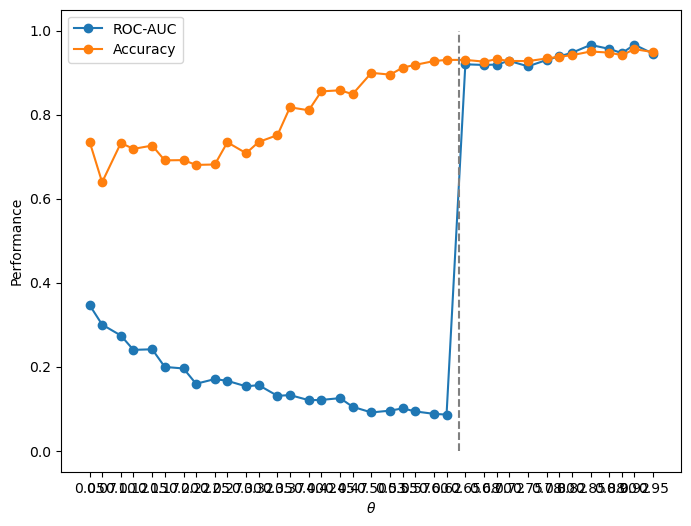

In [417]:
plt.figure(figsize=(8,6))
plt.plot(aurocs.keys(), aurocs.values(), marker="o", label="ROC-AUC")
plt.plot(accuracies.keys(), accuracies.values(), marker="o", label="Accuracy")
plt.xticks(list(aurocs.keys()))
plt.legend()
plt.xlabel("$\\theta$")
plt.ylabel("Performance")
plt.vlines(0.64, 0, 1, linestyles="--", color="gray")

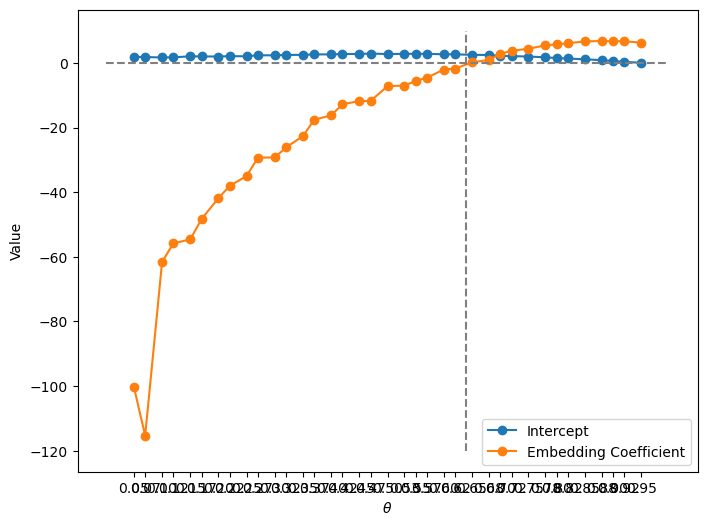

In [418]:
plt.figure(figsize=(8,6))
plt.plot(intercepts.keys(), intercepts.values(), marker="o", label="Intercept")
plt.plot(coefficients.keys(), coefficients.values(), marker="o", label="Embedding Coefficient")
plt.xticks(list(aurocs.keys()))
plt.legend()
plt.xlabel("$\\theta$")
plt.ylabel("Value")
plt.hlines(0, 0, 1, linestyles="--", color="gray")
plt.vlines(0.64, -120, 10, linestyles="--", color="gray")

## Confusion matrix diagnostics

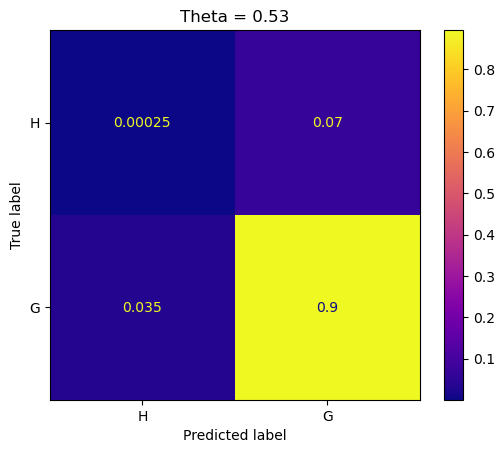

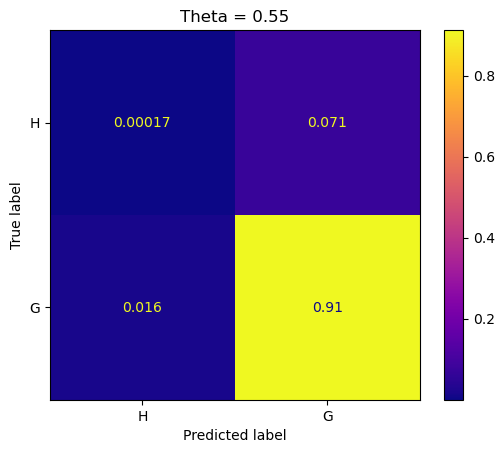

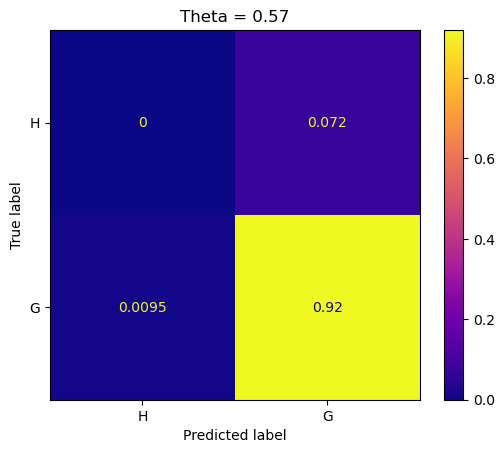

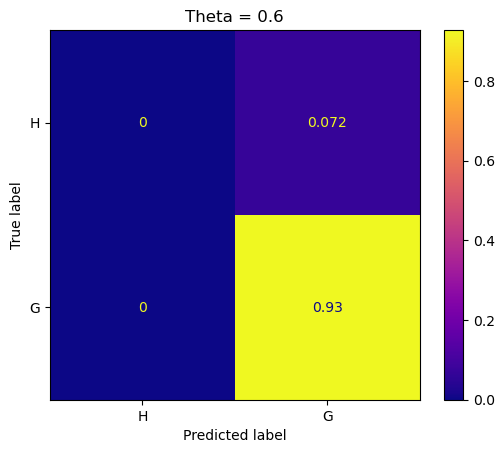

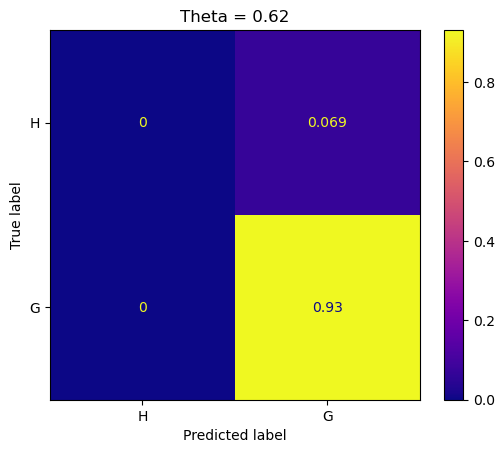

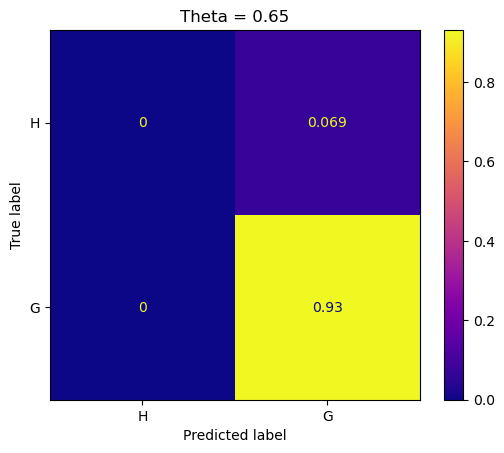

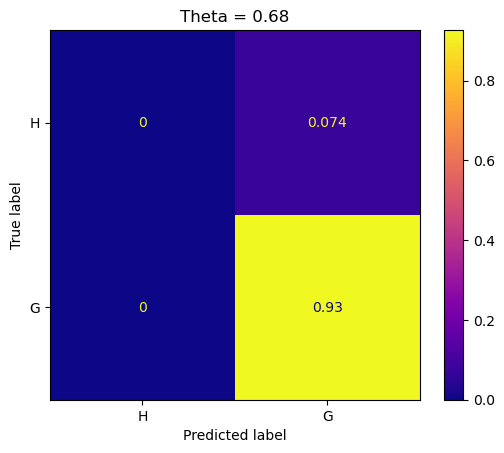

In [419]:
for theta, confusion in confusions.items():
    if 0.5 < theta < 0.7:
        disp = ConfusionMatrixDisplay(confusion, display_labels=["H", "G"])
        disp.plot(cmap="plasma")
        plt.title(f"Theta = {theta}")

## Detailed feature set diagnostics

In [420]:
MIN = 1
INF = 0.5
SUP = 0.7
df_ = melt_dataframe(df.query("@INF < theta < @SUP and distance_G > @MIN and distance_H > @MIN"))

<Figure size 640x480 with 0 Axes>

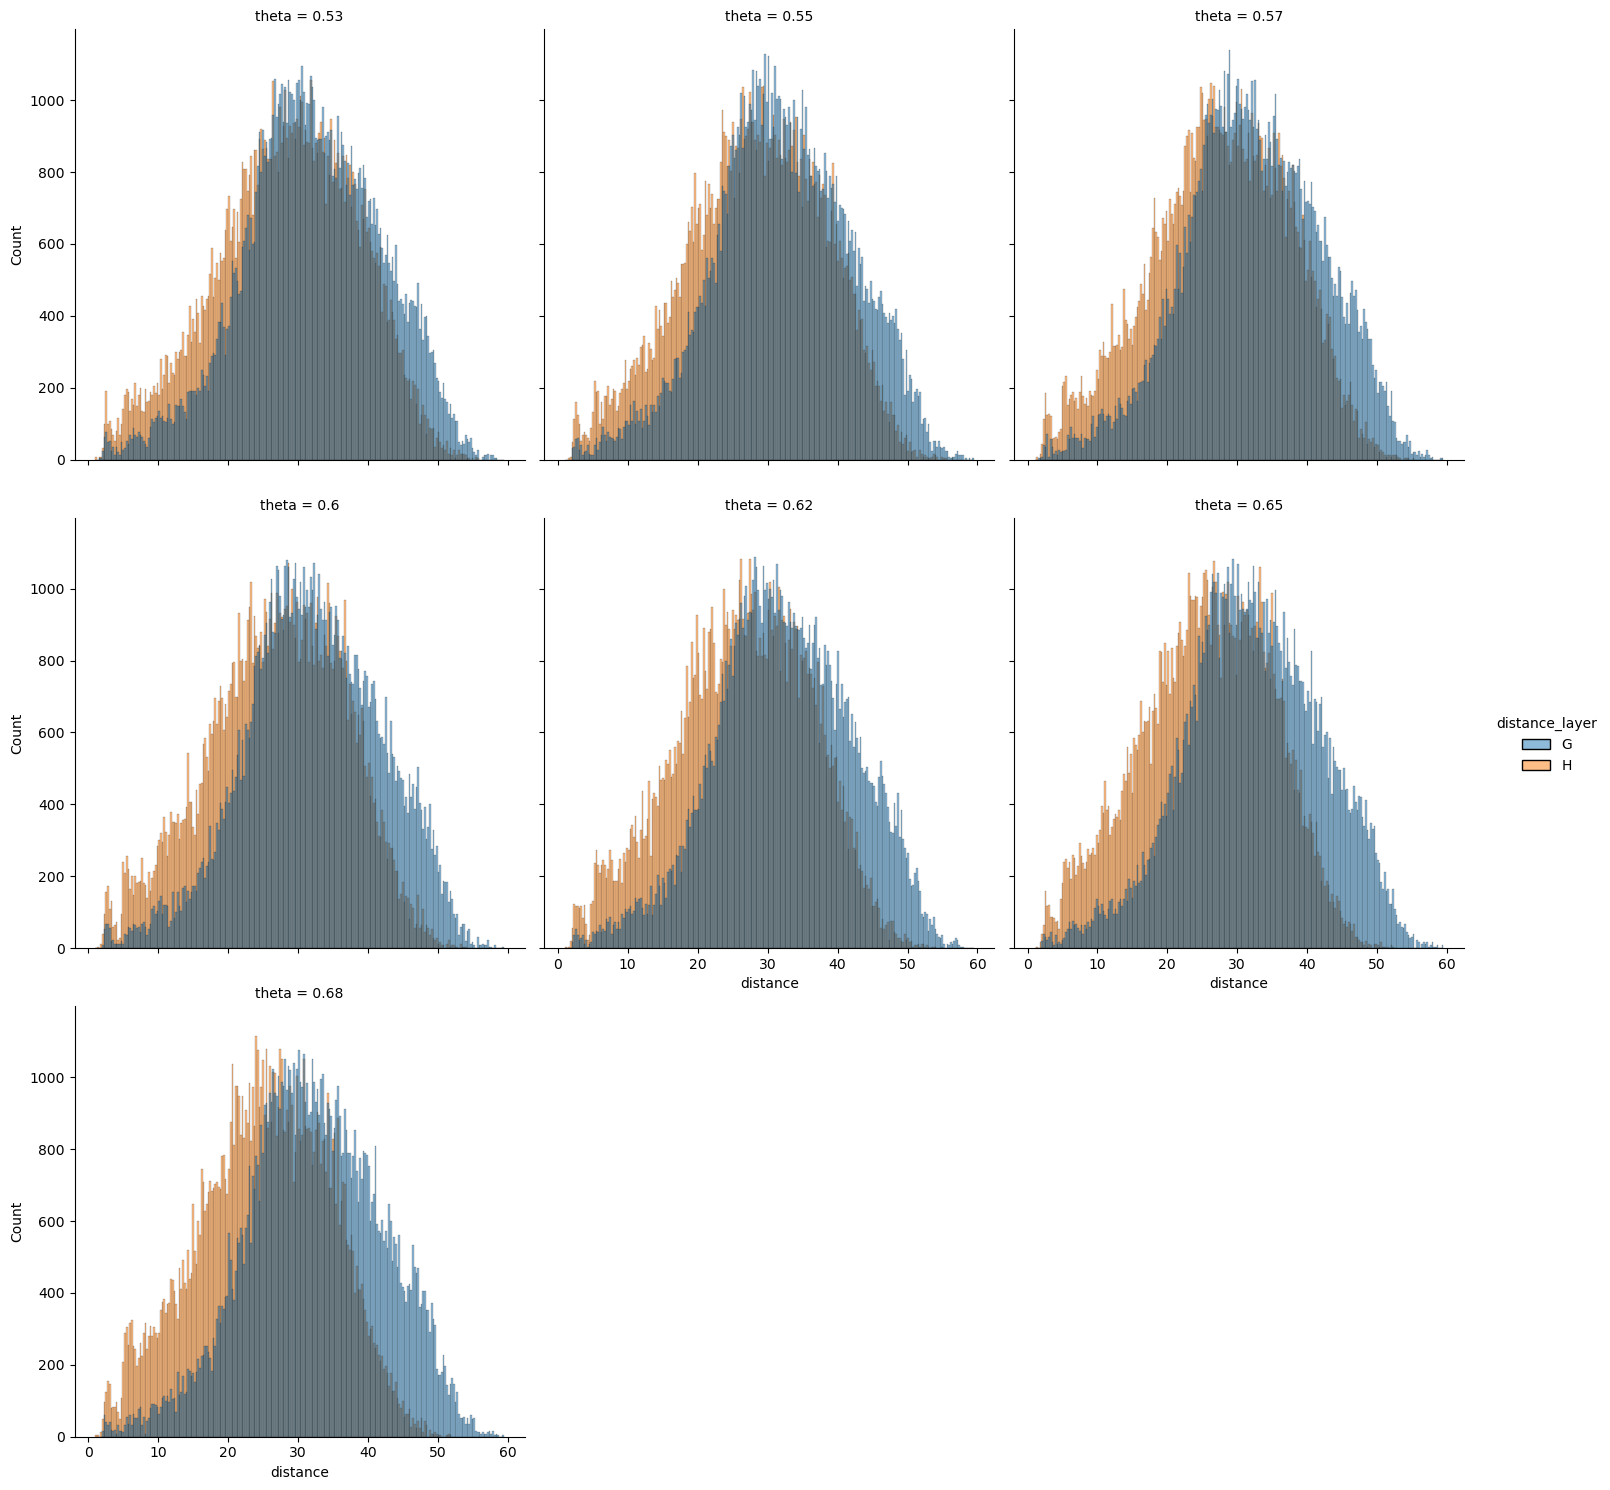

In [421]:
plt.figure()

g = sns.displot(
    data=df_, kind="hist",
    x="distance",
    hue="distance_layer",
    col="theta", col_wrap=3,
)

<Figure size 640x480 with 0 Axes>

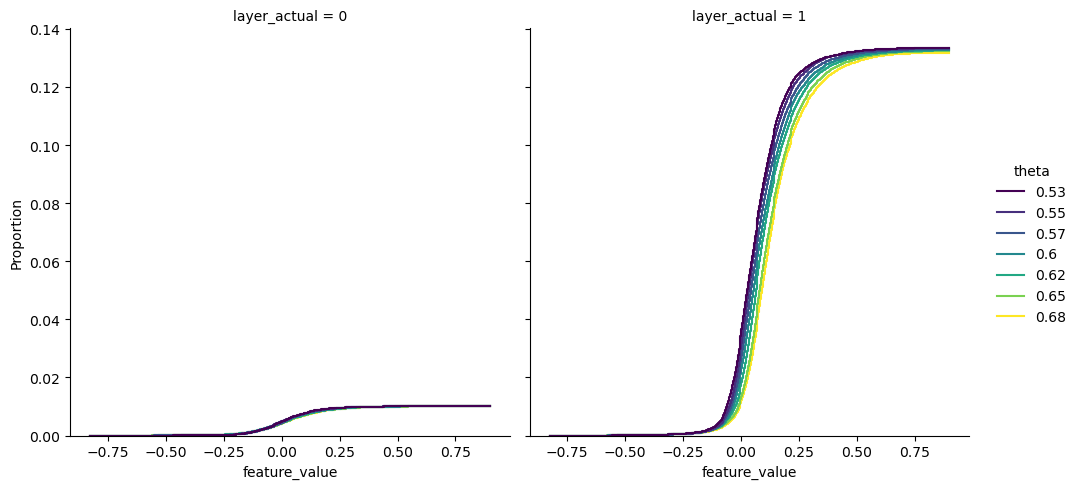

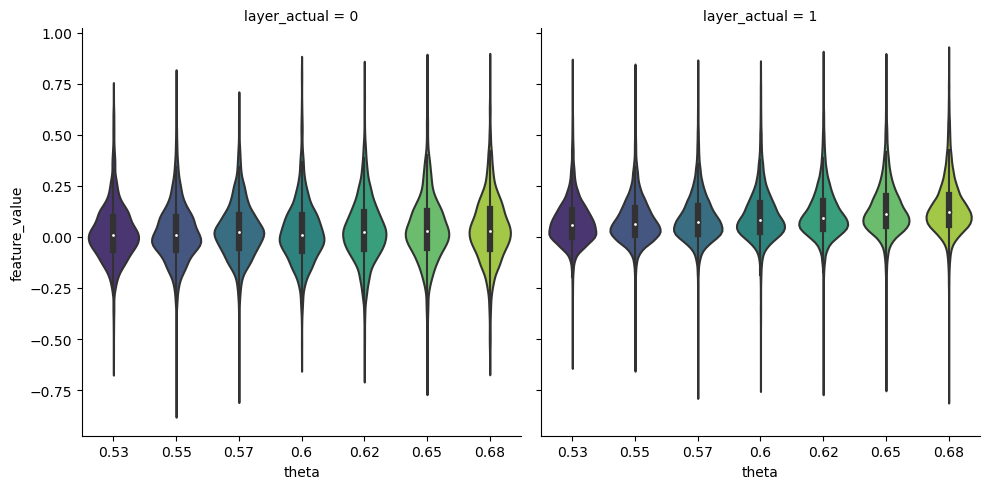

In [422]:
plt.figure()

sns.displot(
    data=df_.query("feature_type == 'Configuration'"), kind="hist",
    x="feature_value",
    col="layer_actual",
    hue="theta", palette="viridis",
    cumulative=True,
    stat="proportion",
    element="step", fill=False
)
sns.catplot(
    data=df_.query("feature_type == 'Configuration'"), kind="violin",
    x="theta", y="feature_value", palette="viridis",
    col="layer_actual"
)
